<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Communication Systems
</font>
<hr/>
<font color="#800080" size=5>
Project 
<br>
</font>
<font size=5>
Amirali Rajaee
<br>
</font>
<font size=4>
Fall 2024
<br>
<hr>
</div></font>

# 1. Importing Libraries

In [1]:
import numpy as np
import cv2
from skimage.util import view_as_blocks
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch

# 2. Functions

In [833]:

# 1. Image Pre-Processing

def preprocess_image(image, block_size=8):
    """ Divide image into 8x8 blocks. """
    
    m, n = image.shape
    assert m % block_size == 0 and n % block_size == 0, "Image dimensions must be divisible by block size"
    blocks = view_as_blocks(image, block_shape=(block_size, block_size))
    
    return blocks.reshape(-1, block_size, block_size)

def dct_transform(blocks):
    """ Apply DCT to each 8x8 block. """
    
    return np.array([cv2.dct(block.astype(np.float32)) for block in blocks])

def quantize(dct_blocks, levels=256):
    """ Quantize DCT coefficients to a fixed number of levels. """
    
    blocks_scaled = dct_blocks / np.max(dct_blocks)
    quantization_values = np.zeros(levels)

    for i in range(levels):
        quantization_values[i] = i / (levels - 1)

    dct_3d_quantization_levels = np.digitize(blocks_scaled,quantization_values) 
    
    return dct_3d_quantization_levels, np.max(dct_blocks)

########################################################################

# 2. Converting to Bitstream

def image_to_bitstream(quantized_blocks,N=32):  # N can be 43, 32, 16, 8, 4, 2 for 'my_image.jpg' (8,4,2 don't work for h1 & h2 in question 21)
    """ Convert quantized DCT coefficients into a bitstream. """
    
    raw_bitstream = np.unpackbits(quantized_blocks.astype(np.uint8), axis=None)
    size = int(raw_bitstream.shape[0] / (N*64))
    bitstream = np.zeros((size,N*64))
    
    for i in range(size):
        bitstream[i] = raw_bitstream[i*(N*64):(i+1)*(N*64)]
        
    return bitstream
    
########################################################################

# 3. Modulation

def pam_modulation(bitstream, pulse_shape, samples_per_bit=32, beta=0.5, K=6):
    """ Perform PAM modulation using specified pulse shape. """
    
    if pulse_shape == 'half_sine':
        t = np.linspace(0, 1, samples_per_bit)
        pulse = np.sin(np.pi*t)
    elif pulse_shape == 'srrc':
        t = np.linspace(-K, K, 2*K*samples_per_bit)
        # SRRC pulse definition
        def srrc_pulse(t, beta, T=1):
            if np.abs(t) < 1e-8:
                return 1 - beta + (4 * beta / np.pi)
            elif np.abs(t) == T / (4 * beta):
                return (beta / np.sqrt(2)) * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
            else:
                return (np.sin(np.pi * t * (1 - beta) / T) + 4 * beta * t / T * np.cos(np.pi * t * (1 + beta) / T)) / (np.pi * t * (1 - (4 * beta * t / T) ** 2) / T)
        
        pulse = np.array([srrc_pulse(i, beta) for i in t])
    else:
        raise ValueError("Unsupported pulse shape")
        
    modulated_signal = np.zeros((bitstream.shape[0],bitstream.shape[1]*samples_per_bit))

    
    if pulse_shape == 'half_sine':
        for i in range(bitstream.shape[0]):
            for j in range(bitstream.shape[1]):
                if bitstream[i,j] > 0:
                    modulated_signal[i,j*samples_per_bit:(j+1)*samples_per_bit] = pulse
                else:
                    modulated_signal[i,j*samples_per_bit:(j+1)*samples_per_bit] = -pulse
    elif pulse_shape == 'srrc':
        for i in range(bitstream.shape[0]):
            for j in range(bitstream.shape[1]):
                if j >= K and j <= bitstream.shape[1]-K:
                    if bitstream[i,j] > 0:
                        modulated_signal[i,((j-K)*samples_per_bit):((j-K)*samples_per_bit+2*K*samples_per_bit)] += pulse
                    else:
                        modulated_signal[i,((j-K)*samples_per_bit):((j-K)*samples_per_bit+2*K*samples_per_bit)] += -pulse
                elif j < K:
                    if bitstream[i,j] > 0:
                        modulated_signal[i,0:((j-K)*samples_per_bit+2*K*samples_per_bit)] += pulse[pulse.shape[0]-((j-K)*samples_per_bit+2*K*samples_per_bit):pulse.shape[0]]
                    else:
                        modulated_signal[i,0:((j-K)*samples_per_bit+2*K*samples_per_bit)] += -pulse[pulse.shape[0]-((j-K)*samples_per_bit+2*K*samples_per_bit):pulse.shape[0]]
                else:
                    if bitstream[i,j] > 0:
                        modulated_signal[i,((j-K)*samples_per_bit):] += pulse[0:pulse.shape[0]-(j-bitstream.shape[1]+K)*32]
                    else:
                        modulated_signal[i,((j-K)*samples_per_bit):] += -pulse[0:pulse.shape[0]-(j-bitstream.shape[1]+K)*32]
    
    return modulated_signal

########################################################################

# 4. Channel

def transmit_through_channel(signal,channel_response):
    """ Simulate transmission through a channel"""

    channel_fft = np.fft.fft(channel_response)
    signal_fft = np.fft.fft(signal)
    transmitted_signal_fft = signal_fft * channel_fft
    transmitted_signal = np.fft.ifft(transmitted_signal_fft)
    
    return np.real(transmitted_signal)

########################################################################

# 5. Noise

def add_white_noise(signal,sigma):
    """ Add noise to received signal at receiver """

    noise = sigma * np.random.randn(signal.shape[0],signal.shape[1])
    noisy_signal = signal + noise

    return noisy_signal

########################################################################

# 6. Matched Filter

def matched_filter(signal, pulse_shape, samples_per_bit=32, beta=0.5, K=6):
    """ Apply a matched filter to the received signal based on the pulse shape. """
    
    if pulse_shape == 'half_sine':
        t = np.linspace(0, 1, samples_per_bit)
        pulse = np.sin(np.pi*t)
    elif pulse_shape == 'srrc':
        t = np.linspace(-K, K, 2*K*samples_per_bit)
        # SRRC pulse definition
        def srrc_pulse(t, beta, T=1):
            t_new = T - t
            if np.abs(t_new) < 1e-8:
                return 1 - beta + (4 * beta / np.pi)
            elif np.abs(t_new) == T / (4 * beta):
                return (beta / np.sqrt(2)) * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
            else:
                return (np.sin(np.pi * t_new * (1 - beta) / T) + 4 * beta * t_new / T * np.cos(np.pi * t_new * (1 + beta) / T)) / (np.pi * t_new * (1 - (4 * beta * t_new / T) ** 2) / T)
        
        pulse = np.array([srrc_pulse(i, beta) for i in t])
    else:
        raise ValueError("Unsupported pulse shape")

    filtered_signal = np.zeros_like(signal)

    for i in range(filtered_signal.shape[0]):
        filtered_signal[i,:] = np.convolve(signal[i,:], pulse, mode='same')
    
    return filtered_signal

########################################################################

# 7. Equalization

def zero_forcing_equalizer(signal, channel_response):
    """ Apply Zero-Forcing equalization. """
    
    channel_inverse_response_fft = 1 / np.fft.fft(channel_response)
    equalized_signal = np.zeros_like(signal,dtype = 'complex_')
    
    for i in range(equalized_signal.shape[0]):
        signal_fft = np.fft.fft(signal[i,:])
        equalized_signal[i,:] = np.fft.ifft(signal_fft * channel_inverse_response_fft)
    
    return np.real(equalized_signal)

def mmse_equalizer(signal, channel_response, noise_power):
    """ Apply MMSE equalization. """
    
    H = np.fft.fft(channel_response)
    H_conj = np.conj(H)
    mmse_filter_fft = H_conj / (H * H_conj + 2*noise_power)

    equalized_signal = np.zeros_like(signal,dtype = 'complex_')
    
    for i in range(equalized_signal.shape[0]):
        signal_fft = np.fft.fft(signal[i,:])
        equalized_signal[i,:] = np.fft.ifft(signal_fft * mmse_filter_fft)
        
    return np.real(equalized_signal)

########################################################################

# 8. Smapling and Detection

def sample_and_detect(signal, pulse_shape, samples_per_bit=32):
    """ Sample the received signal at optimal points and detect the transmitted bits. """
    
    detected_signal = np.zeros((signal.shape[0],int(signal.shape[1]/samples_per_bit)))
    
    if pulse_shape == 'half_sine':
        for i in range(detected_signal.shape[0]):
            for j in range(detected_signal.shape[1]):
                detected_signal[i,j] = (signal[i,j*samples_per_bit+int(samples_per_bit/2)] > 0).astype(np.uint8)
    elif pulse_shape == 'srrc':
        for i in range(detected_signal.shape[0]):
            for j in range(detected_signal.shape[1]):
                detected_signal[i,j] = (signal[i,j*samples_per_bit+samples_per_bit-1] > 0).astype(np.uint8)
    else:
        raise ValueError("Unsupported pulse shape")

    detected_bits = detected_signal.flatten().astype(np.uint8)
    
    return detected_bits

########################################################################

# 9,10. Image Reconstruction (Post-Processing)

def reconstruct_image(detected_bits, image_shape, max_value, block_size=8, levels=256):
    """ Reconstruct the image from detected bits. """
    
    num_blocks = (image_shape[0] // block_size) * (image_shape[1] // block_size)
    total_bits_needed = num_blocks * block_size * block_size * 8  # Each pixel is 8 bits
    
    # Ensure detected_bits has enough elements
    if len(detected_bits) < total_bits_needed:
        raise ValueError("Insufficient detected bits to reconstruct the image")
    
    quantized_blocks = np.packbits(detected_bits[:total_bits_needed])
    quantized_blocks = quantized_blocks.reshape(num_blocks, block_size, block_size)
    
    # Apply inverse quantization
    dct_blocks = (quantized_blocks).astype(np.float32)
    
    # Apply inverse DCT to each block
    image_blocks = np.array([cv2.idct(block) * max_value / 255 for block in dct_blocks])
    
    # Reshape blocks into original image dimensions
    reconstructed_image = np.block([[image_blocks[i * (image_shape[1] // block_size) + j] 
                                     for j in range(image_shape[1] // block_size)] 
                                    for i in range(image_shape[0] // block_size)])
    
    return reconstructed_image

# 3. Blockwise Implementation

## 3.1. Image Pre-Processing

I use a portrait of myself for this project, not because I'm a narcissistic psychopath :) , but because it has a small size so the code runs faster.

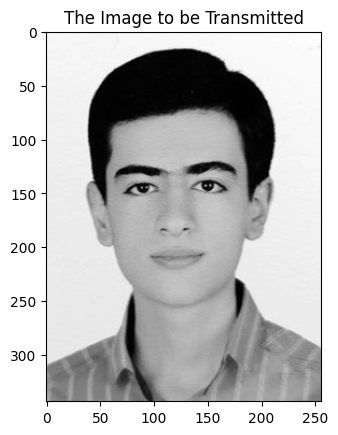

In [746]:
image = cv2.imread("my_image.jpg", cv2.IMREAD_GRAYSCALE)
image_blocks = preprocess_image(image)
dct_blocks = dct_transform(image_blocks)
quantized_blocks, max_value = quantize(dct_blocks)

plt.imshow(image,cmap=plt.cm.gray)
plt.title('The Image to be Transmitted')
plt.show()

## 3.2. Converting to Bitstream

Parameter N can be modified at the "Functions" part.

In [747]:
bitstream = image_to_bitstream(quantized_blocks)
bitstream.shape

(344, 2048)

## 3.3. Modulation

Parameters sample per bit, beta and K can be modified at the "Functions" part.

In [748]:
modulated_signal_sine = pam_modulation(bitstream,'half_sine')
modulated_signal_srrc = pam_modulation(bitstream,'srrc')

#### Question 1:

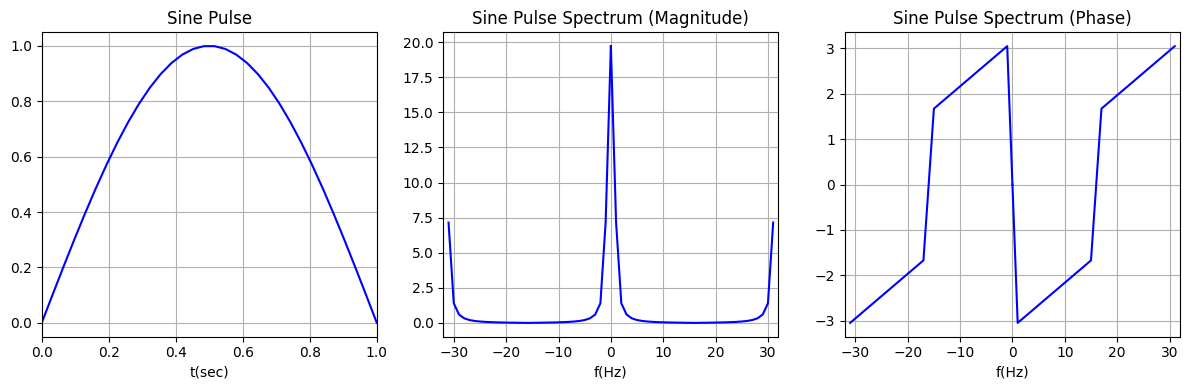

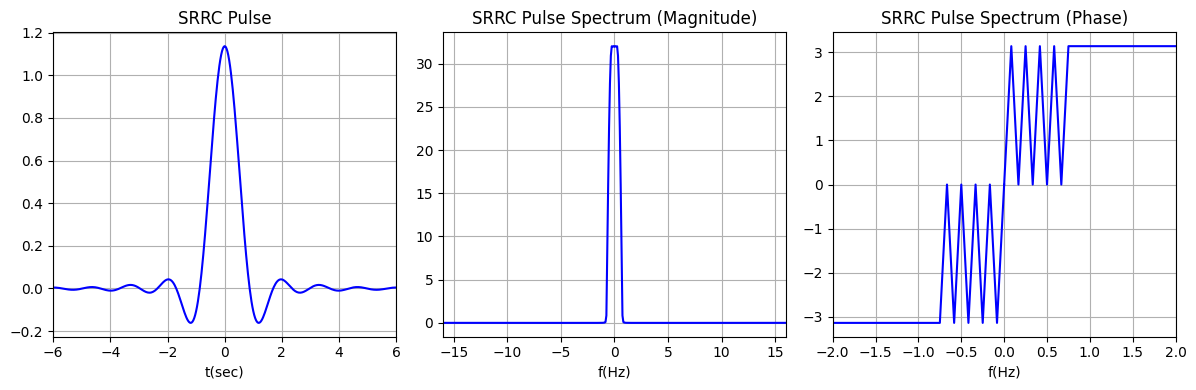

In [749]:
t = np.linspace(0, 1, 32)
pulse = np.sin(np.pi*t)
Fs = 32
fft_values = np.fft.fft(pulse)
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.plot(t,pulse,color='blue')
plt.title('Sine Pulse')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

plt.subplot(1, 3, 2)
plt.plot(freq, np.abs(fft_values), color='blue')
plt.plot(-freq, np.abs(fft_values), color='blue')
plt.title('Sine Pulse Spectrum (Magnitude)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-32,32)

plt.subplot(1, 3, 3)
plt.plot(freq, np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.plot(-freq, -np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.title('Sine Pulse Spectrum (Phase)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-32,32)

plt.tight_layout()
plt.show()

def srrc_pulse(t, beta, T=1):
            if np.abs(t) < 1e-8:
                return 1 - beta + (4 * beta / np.pi)
            elif np.abs(t) == T / (4 * beta):
                return (beta / np.sqrt(2)) * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
            else:
                return (np.sin(np.pi * t * (1 - beta) / T) + 4 * beta * t / T * np.cos(np.pi * t * (1 + beta) / T)) / (np.pi * t * (1 - (4 * beta * t / T) ** 2) / T)

K = 6
beta = 0.5
t = np.linspace(-K, K, 2*K*32, endpoint=False)
pulse = np.array([srrc_pulse(i, beta) for i in t])

Fs = 32
fft_values = np.fft.fft(pulse)
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.plot(t,pulse,color='blue')
plt.title('SRRC Pulse')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(-K,K)

plt.subplot(1, 3, 2)
plt.plot(freq, np.abs(fft_values), color='blue')
plt.plot(-freq, np.abs(fft_values), color='blue')
plt.title('SRRC Pulse Spectrum (Magnitude)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-16,16)

plt.subplot(1, 3, 3)
plt.plot(freq, np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.plot(-freq, -np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.title('SRRC Pulse Spectrum (Phase)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-2,2)

plt.tight_layout()
plt.show()

I didn't plot the magnitude diagram in dB scale, because the similarity between the spectrum of a single bit and a whole message cosisting of thousands of bits can be shown better in linear scale. But you can change 'plt.plot' to 'plt.semilogy' to see the the plot in dB scale.

#### Question 2

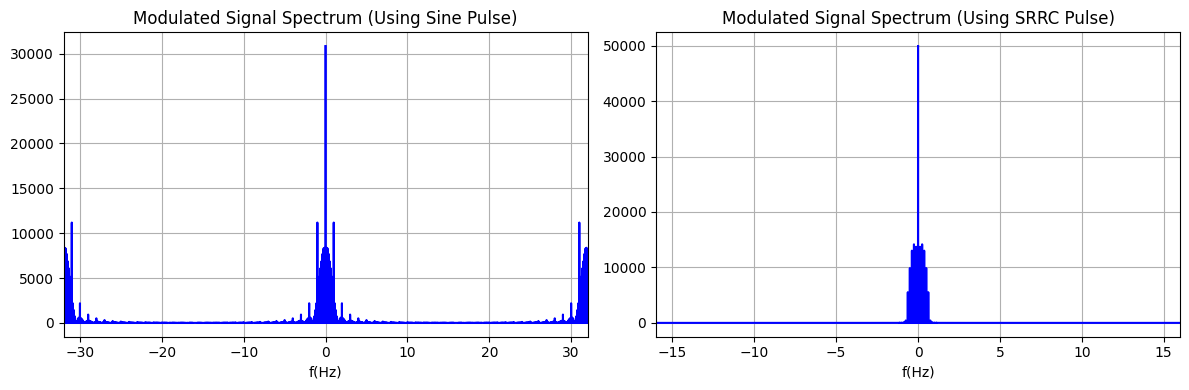

In [750]:
plt.figure(figsize=(12,4))

Fs = 32
fft_values = np.fft.fft(modulated_signal_sine[0])
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T
abs = np.abs(fft_values)

plt.subplot(1,2,1)
plt.plot(freq, abs, color='blue')
plt.plot(-freq, abs, color='blue')
plt.title('Modulated Signal Spectrum (Using Sine Pulse)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-32,32)

Fs = 32
fft_values = np.fft.fft(modulated_signal_srrc[0])
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T
abs = np.abs(fft_values)

plt.subplot(1,2,2)
plt.plot(freq, abs, color='blue')
plt.plot(-freq, abs, color='blue')
plt.title('Modulated Signal Spectrum (Using SRRC Pulse)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-16,16)

plt.tight_layout()
plt.show()

As you can see, there's a significant similarity between the spectrum of a single bit pulse and the spectrum of a whole message modulated by that pulse.

#### Question 3

Note that our bitsream doesn't have a random charcteristic, and at numerous parts thers are a lot of consecutive ones or consecutive zeros. So don't run this section of the code if not necessary, because the sampled bit sequence may change to a non-unique and "not-interesting" sequence.

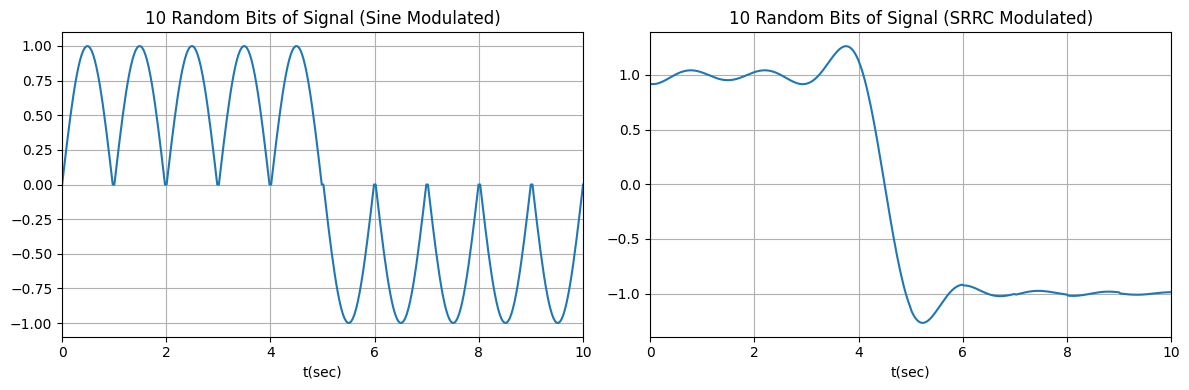

In [547]:
plt.figure(figsize=(12,4))

t = np.linspace(0,10,10*32)
i_random = np.random.randint(0,bitstream.shape[0])
j_random = np.random.randint(0,bitstream.shape[1])

modulated_signal_sine_10bit = modulated_signal_sine[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,1)
plt.plot(t,modulated_signal_sine_10bit)
plt.title('10 Random Bits of Signal (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

modulated_signal_srrc_10bit = modulated_signal_srrc[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,2)
plt.plot(t,modulated_signal_srrc_10bit)
plt.title('10 Random Bits of Signal (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

plt.tight_layout()
plt.show()

As we can see, the sine modulated signal is an RZ line code; however, the SRRC modulated signal is an NRZ line code.

#### Question 4

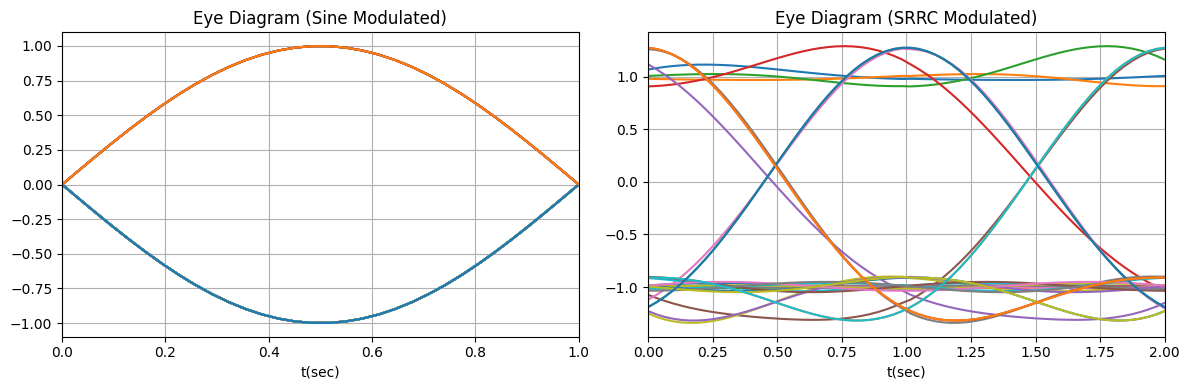

In [751]:
plt.figure(figsize=(12,4))

t = np.linspace(0,1,32)

for i in range(int(modulated_signal_sine.shape[1]/bitstream.shape[1])):
    bit = modulated_signal_sine[2,i*32:(i+1)*32]
    plt.subplot(1,2,1)
    plt.plot(t,bit)

plt.title('Eye Diagram (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

t = np.linspace(0,2,64)

for i in range(int(modulated_signal_srrc.shape[1]/bitstream.shape[1])):
    bit = modulated_signal_srrc[2,i*32:(i+2)*32]
    plt.subplot(1,2,2)
    plt.plot(t,bit)

plt.title('Eye Diagram (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,2)

plt.tight_layout()
plt.show()

We can see the eye-opening area perfectly in both cases.

## 3.4. Channel

In [752]:
channel = np.zeros_like(modulated_signal_sine[0,:])
channel[0] = 1
channel[32] = 1/2
channel[64] = 3/4
channel[96] = -2/7

received_signal_sine = np.zeros_like(modulated_signal_sine)
received_signal_srrc = np.zeros_like(modulated_signal_srrc)

for i in range(received_signal_sine.shape[0]):
    received_signal_sine[i,:] = transmit_through_channel(modulated_signal_sine[i,:],channel)

for i in range(received_signal_srrc.shape[0]):
    received_signal_srrc[i,:] = transmit_through_channel(modulated_signal_srrc[i,:],channel)

#### Question 5

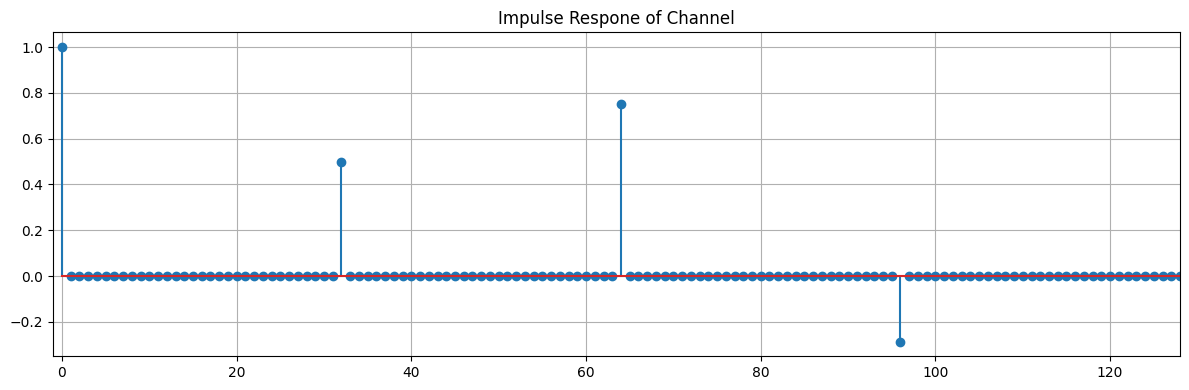

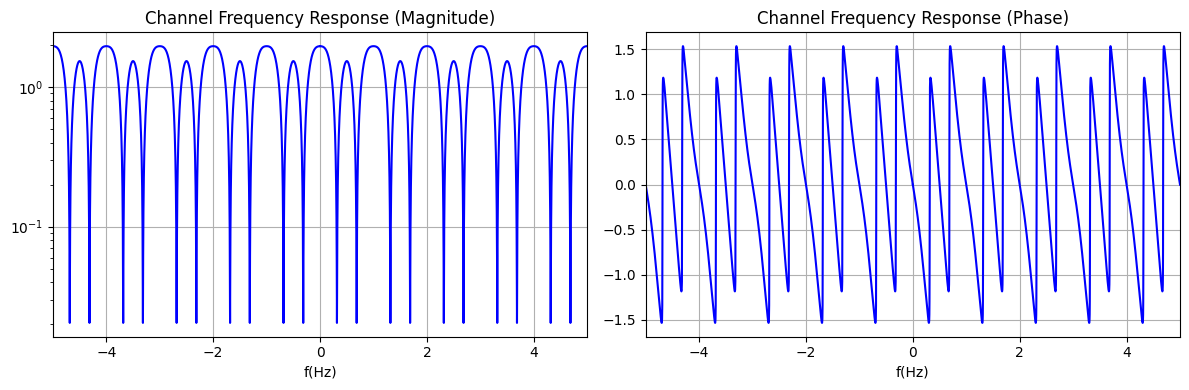

In [753]:
plt.figure(figsize=(12,4))

plt.stem(channel)
plt.title('Impulse Respone of Channel')
plt.grid(True)
plt.xlim(-1,128)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

Fs = 32
fft_values = np.fft.fft(channel)
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T
abs = np.abs(fft_values)

plt.subplot(1,2,1)
plt.semilogy(freq, abs, color='blue')
plt.semilogy(-freq, abs, color='blue')
plt.title('Channel Frequency Response (Magnitude)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-5,5)

plt.subplot(1,2,2)
plt.plot(freq, np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.plot(-freq, -np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.title('Channel Frequency Response (Phase)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-5,5)

plt.tight_layout()
plt.show()

#### Question 6

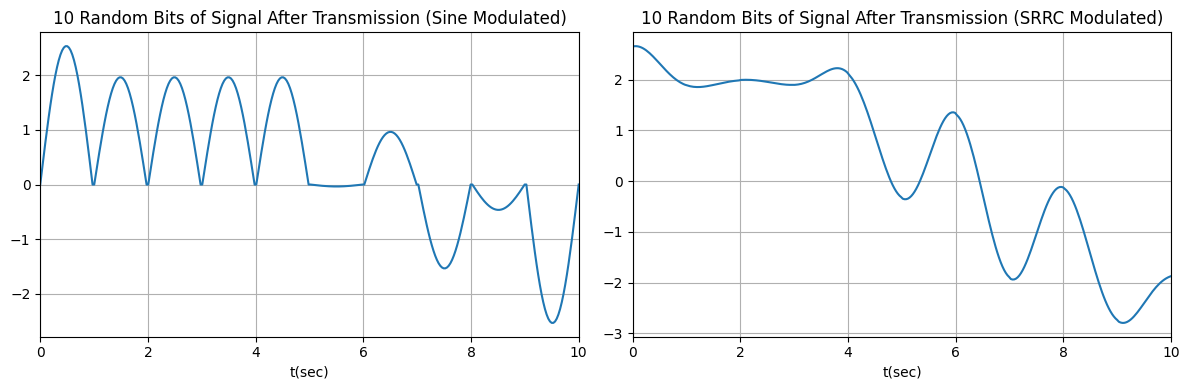

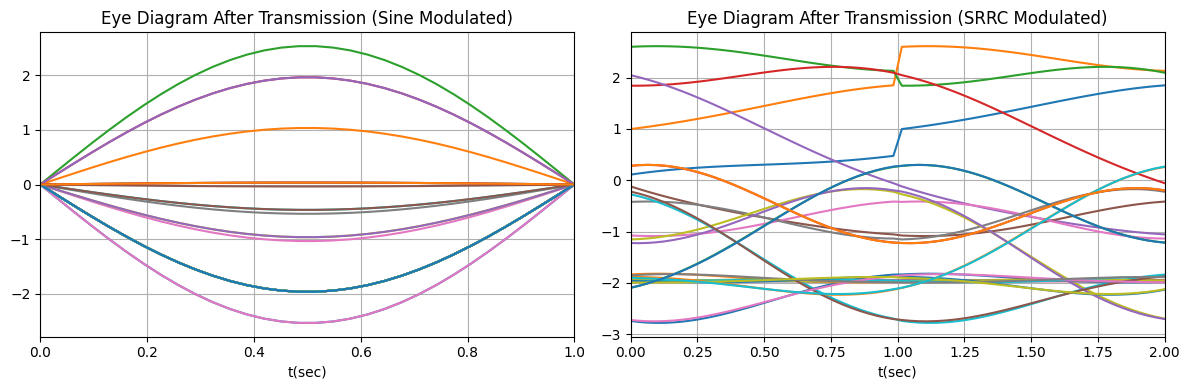

In [754]:
plt.figure(figsize=(12,4))

t = np.linspace(0,10,10*32)

modulated_signal_sine_10bit_transmitted_through_channel = received_signal_sine[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,1)
plt.plot(t,modulated_signal_sine_10bit_transmitted_through_channel)
plt.title('10 Random Bits of Signal After Transmission (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

modulated_signal_srrc_10bit_transmitted_through_channel = received_signal_srrc[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,2)
plt.plot(t,modulated_signal_srrc_10bit_transmitted_through_channel)
plt.title('10 Random Bits of Signal After Transmission (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

t = np.linspace(0,1,32)

for i in range(int(received_signal_sine.shape[1]/bitstream.shape[1])):
    bit = received_signal_sine[2,i*32:(i+1)*32]
    plt.subplot(1,2,1)
    plt.plot(t,bit)

plt.title('Eye Diagram After Transmission (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

t = np.linspace(0,2,64)

for i in range(int(received_signal_srrc.shape[1]/bitstream.shape[1])):
    bit = received_signal_srrc[2,i*32:(i+2)*32]
    plt.subplot(1,2,2)
    plt.plot(t,bit)

plt.title('Eye Diagram After Transmission (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,2)

plt.tight_layout()
plt.show()

As we can see, ISI has strongly affected the eye-opening area in both cases especially the SRRC line code.
In the presence of ISI, the lines will tend to deviate from their positions and therefore the eye will get demolisheds.

## 3.5. Noise

In [794]:
noise_power = 0.01
received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

#### Question 7

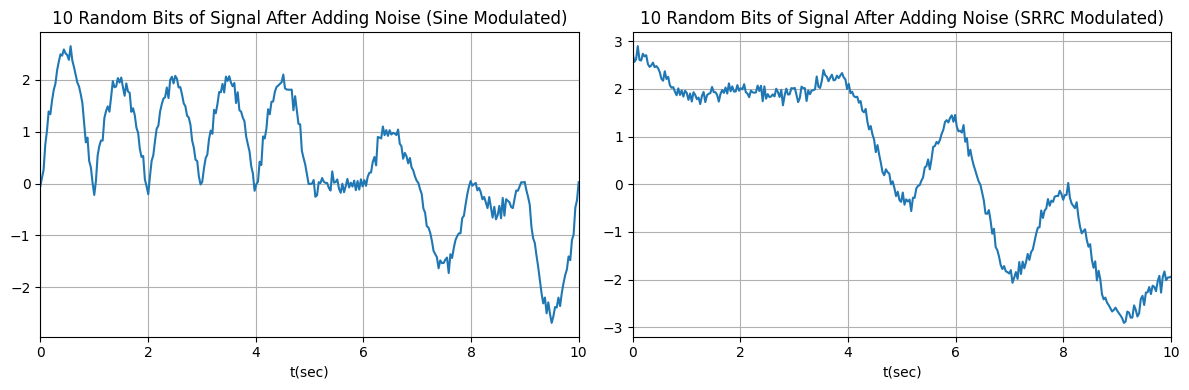

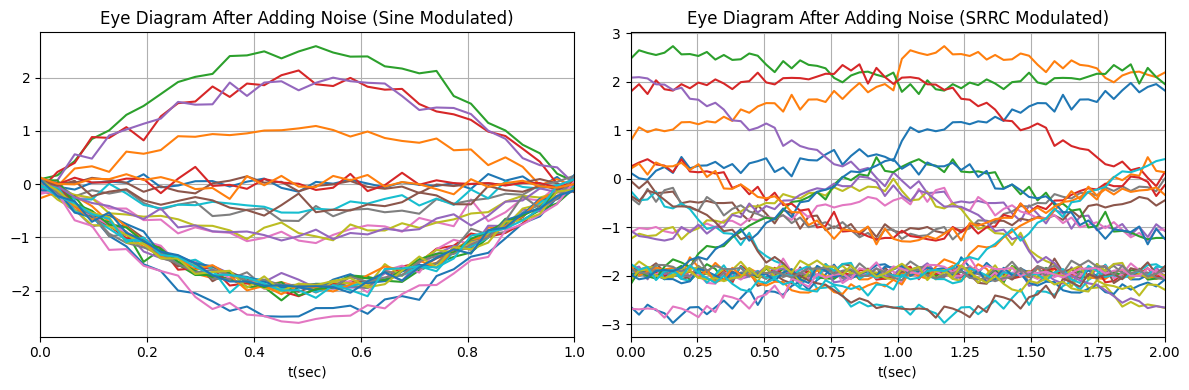

In [795]:
plt.figure(figsize=(12,4))

t = np.linspace(0,10,10*32)

received_signal_sine_10bit_noisy = received_noisy_signal_sine[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,1)
plt.plot(t,received_signal_sine_10bit_noisy)
plt.title('10 Random Bits of Signal After Adding Noise (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

received_signal_srrc_10bit_noisy = received_noisy_signal_srrc[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,2)
plt.plot(t,received_signal_srrc_10bit_noisy)
plt.title('10 Random Bits of Signal After Adding Noise (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

t = np.linspace(0,1,32)

for i in range(int(received_noisy_signal_sine.shape[1]/bitstream.shape[1])):
    bit = received_noisy_signal_sine[2,i*32:(i+1)*32]
    plt.subplot(1,2,1)
    plt.plot(t,bit)

plt.title('Eye Diagram After Adding Noise (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

t = np.linspace(0,2,64)

for i in range(int(received_noisy_signal_srrc.shape[1]/bitstream.shape[1])):
    bit = received_noisy_signal_srrc[2,i*32:(i+2)*32]
    plt.subplot(1,2,2)
    plt.plot(t,bit)

plt.title('Eye Diagram After Adding Noise (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,2)

plt.tight_layout()
plt.show()

Just like ISI, noise also affects the eye diagram. In the presence of additive channel noise, the eye will 
tend to close partially in all cases.

## 3.6. Matched Filter

In [796]:
matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

#### Question 8

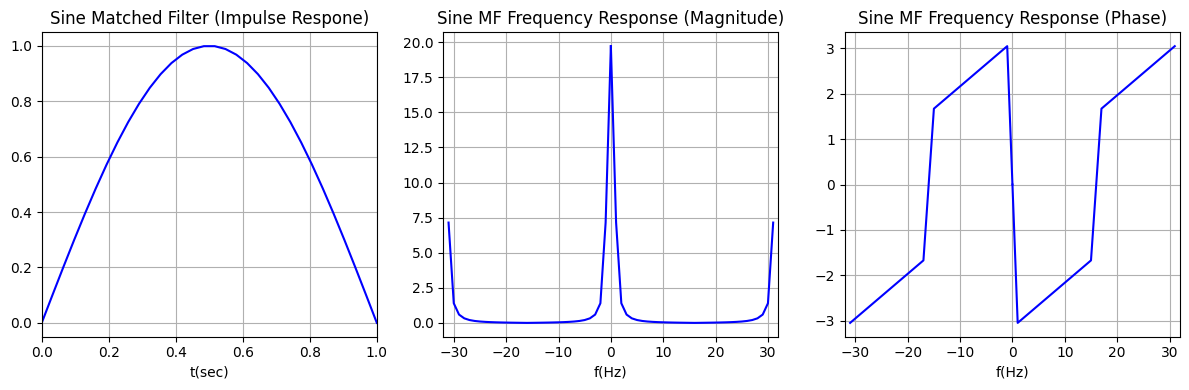

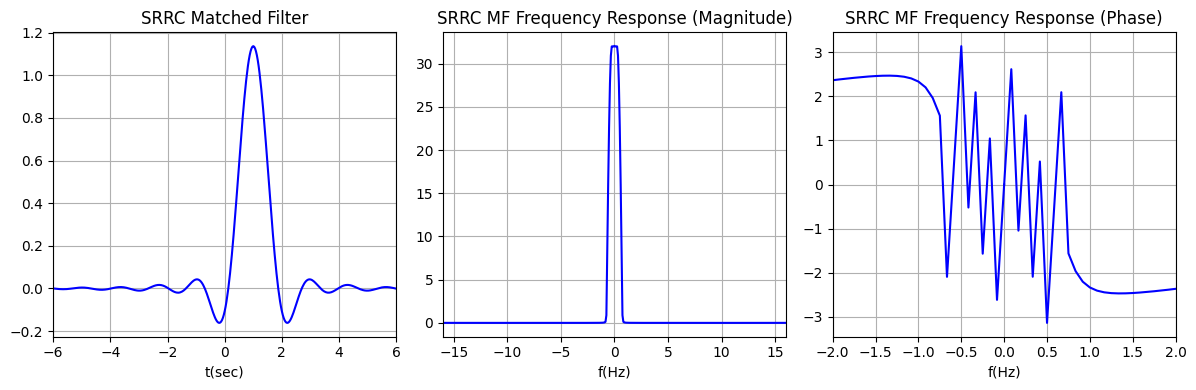

In [797]:
t = np.linspace(0, 1, 32)
pulse = np.sin(np.pi*t)
Fs = 32
fft_values = np.fft.fft(pulse)
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.plot(t,pulse,color='blue')
plt.title('Sine Matched Filter (Impulse Respone)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

plt.subplot(1, 3, 2)
plt.plot(freq, np.abs(fft_values), color='blue')
plt.plot(-freq, np.abs(fft_values), color='blue')
plt.title('Sine MF Frequency Response (Magnitude)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-32,32)

plt.subplot(1, 3, 3)
plt.plot(freq, np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.plot(-freq, -np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.title('Sine MF Frequency Response (Phase)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-32,32)

plt.tight_layout()
plt.show()

def srrc_pulse(t, beta, T=1):
    t_new = T - t
    if np.abs(t_new) < 1e-8:
        return 1 - beta + (4 * beta / np.pi)
    elif np.abs(t_new) == T / (4 * beta):
        return (beta / np.sqrt(2)) * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
    else:
        return (np.sin(np.pi * t_new * (1 - beta) / T) + 4 * beta * t_new / T * np.cos(np.pi * t_new * (1 + beta) / T)) / (np.pi * t_new * (1 - (4 * beta * t_new / T) ** 2) / T)

K = 6
beta = 0.5
t = np.linspace(-K, K, 2*K*32, endpoint=False)
pulse = np.array([srrc_pulse(i, beta) for i in t])

Fs = 32
fft_values = np.fft.fft(pulse)
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.plot(t,pulse,color='blue')
plt.title('SRRC Matched Filter')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(-K,K)

plt.subplot(1, 3, 2)
plt.plot(freq, np.abs(fft_values), color='blue')
plt.plot(-freq, np.abs(fft_values), color='blue')
plt.title('SRRC MF Frequency Response (Magnitude)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-16,16)

plt.subplot(1, 3, 3)
plt.plot(freq, np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.plot(-freq, -np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.title('SRRC MF Frequency Response (Phase)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-2,2)

plt.tight_layout()
plt.show()

For the sine pulse, the matched filter impulse response is the sine pulse itself, and for the SRRC pulse, the matched filter impulse response is the shifted version of the SRRC pulse.

#### Question 9

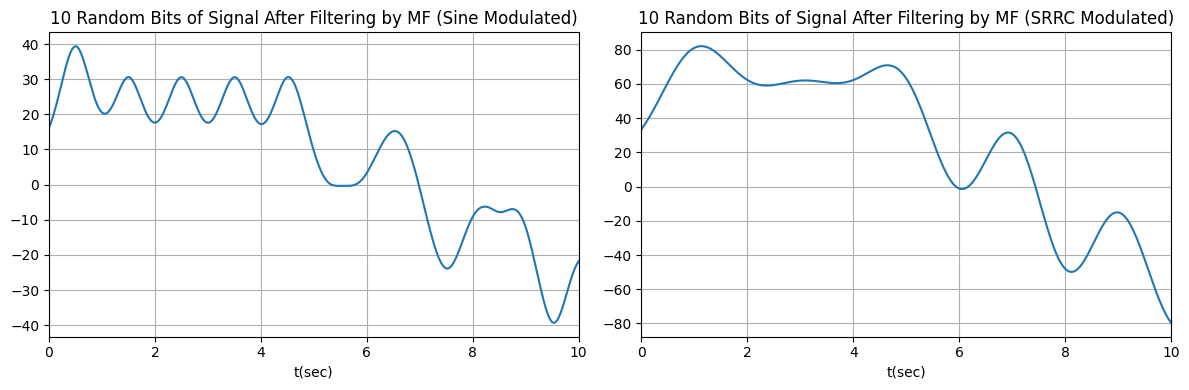

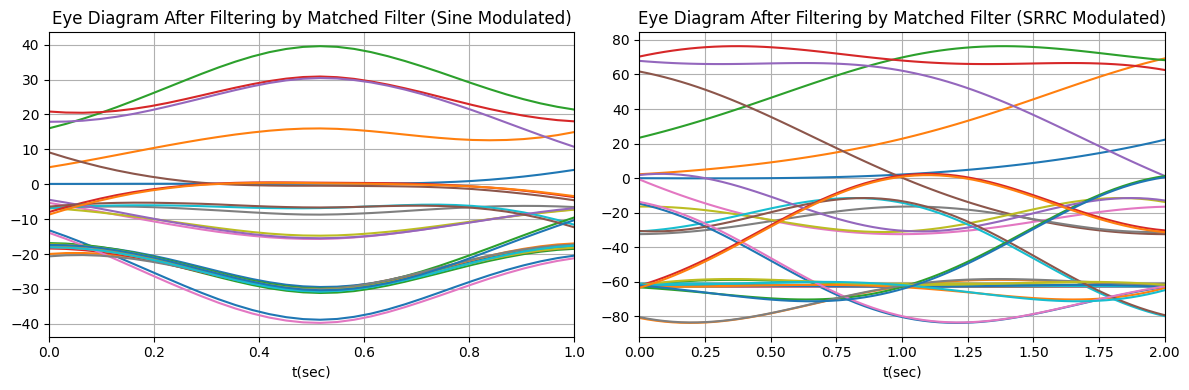

In [798]:
plt.figure(figsize=(12,4))

t = np.linspace(0,10,10*32)

matched_signal_sine_10bit = matched_signal_sine[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,1)
plt.plot(t,matched_signal_sine_10bit)
plt.title('10 Random Bits of Signal After Filtering by MF (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

matched_signal_srrc_10bit = matched_signal_srrc[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,2)
plt.plot(t,matched_signal_srrc_10bit)
plt.title('10 Random Bits of Signal After Filtering by MF (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

t = np.linspace(0,1,32)

for i in range(int(matched_signal_sine.shape[1]/bitstream.shape[1])):
    bit = matched_signal_sine[2,i*32:(i+1)*32]
    plt.subplot(1,2,1)
    plt.plot(t,bit)

plt.title('Eye Diagram After Filtering by Matched Filter (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

t = np.linspace(0,2,64)

for i in range(int(matched_signal_srrc.shape[1]/bitstream.shape[1])):
    bit = matched_signal_srrc[2,i*32:(i+2)*32]
    plt.subplot(1,2,2)
    plt.plot(t,bit)

plt.title('Eye Diagram After Filtering by Matched Filter (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,2)

plt.tight_layout()
plt.show()

It seems that the best sampling point for the sine modulated signal is 0.5+nT, but for the SSRC modulated signal, we can't decide yet.

## 3.7. Equalizer

#### Zero Forcing Equalizer

In [799]:
zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

#### Question 10

In order to implement zero-forcing equalizer, we calculate the FFT of channel response and inverse it. Then we multiply it by the FFT of our signal and finally we calculate the inverse FFT of the resulted product. (You can refer to the "zero_forcing_equalizer" function at the "Functions" part.) 

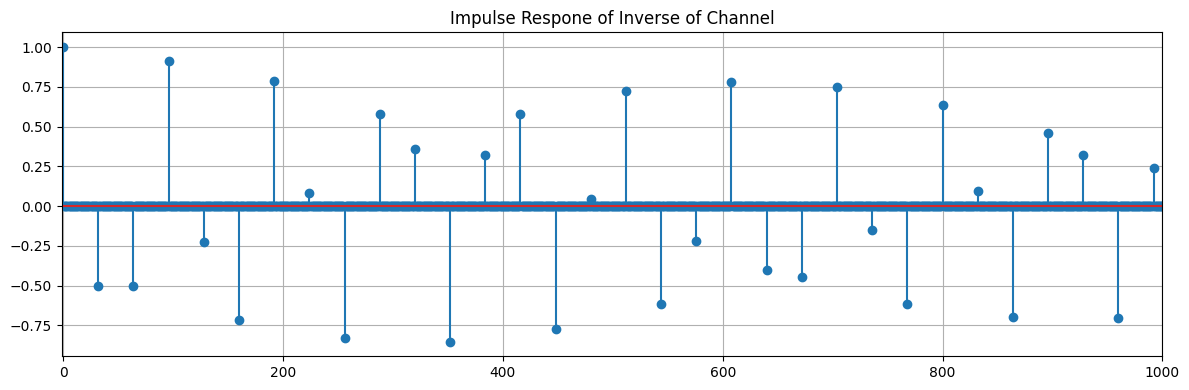

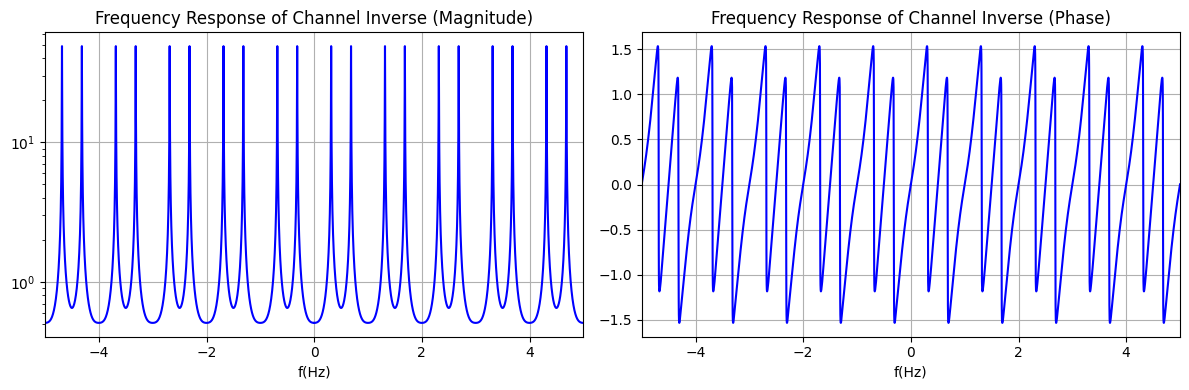

In [800]:
inverse_response = np.fft.ifft(1 / np.fft.fft(channel))

plt.figure(figsize=(12,4))

plt.stem(inverse_response)
plt.title('Impulse Respone of Inverse of Channel')
plt.grid(True)
plt.xlim(-1,1000)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

Fs = 32
fft_values = np.fft.fft(inverse_response)
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T
abs = np.abs(fft_values)

plt.subplot(1,2,1)
plt.semilogy(freq, abs, color='blue')
plt.semilogy(-freq, abs, color='blue')
plt.title('Frequency Response of Channel Inverse (Magnitude)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-5,5)

plt.subplot(1,2,2)
plt.plot(freq, np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.plot(-freq, -np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.title('Frequency Response of Channel Inverse (Phase)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-5,5)

plt.tight_layout()
plt.show()

As we can see, the zero-forcing filter doesn't seem to be stable, since the impulse response is not converging.

#### Question 11

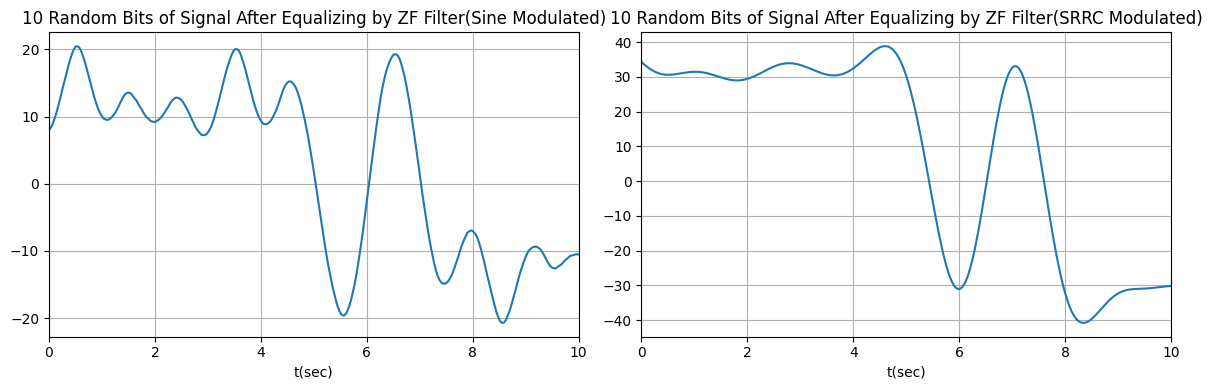

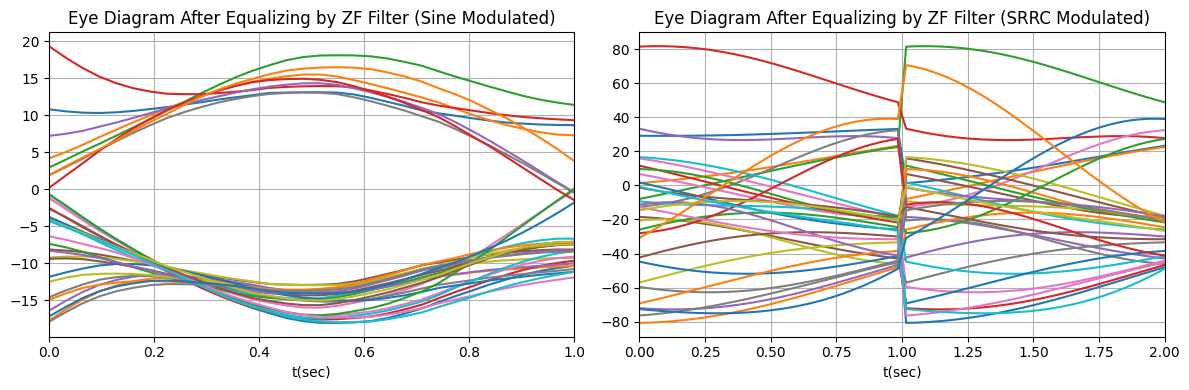

In [801]:
plt.figure(figsize=(12,4))

t = np.linspace(0,10,10*32)

zf_equalized_signal_sine_10bit = zf_signal_sine[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,1)
plt.plot(t,zf_equalized_signal_sine_10bit)
plt.title('10 Random Bits of Signal After Equalizing by ZF Filter(Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

zf_equalized_srrc_10bit = zf_signal_srrc[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,2)
plt.plot(t,zf_equalized_srrc_10bit)
plt.title('10 Random Bits of Signal After Equalizing by ZF Filter(SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

t = np.linspace(0,1,32)

for i in range(int(zf_signal_sine.shape[1]/bitstream.shape[1])):
    bit = zf_signal_sine[2,i*32:(i+1)*32]
    plt.subplot(1,2,1)
    plt.plot(t,bit)

plt.title('Eye Diagram After Equalizing by ZF Filter (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

t = np.linspace(0,2,64)

for i in range(int(zf_signal_srrc.shape[1]/bitstream.shape[1])):
    bit = zf_signal_srrc[2,i*32:(i+2)*32]
    plt.subplot(1,2,2)
    plt.plot(t,bit)

plt.title('Eye Diagram After Equalizing by ZF Filter (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,2)

plt.tight_layout()
plt.show()

As we can see, the zero-forcing filter works almost acceptable for the sine modulated signal but does not work well for SSRC modulated signal. This is mainly because of noise. The zreo-forcing filter has high sensitivity against noise.

#### MMSE Equalizer

In [802]:
mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

#### Question 12

In order to implement MMSE equalizer, we follow the same approach as the zero-forcing equalizer. We calculate the FFT of channel and hence its conjugate. Then we form the MMSE equalizer expression in frequency domain and multiply it by FFT of our signal and finally, we calculate the inverse FFT of the resulted product. (You can refer to the "mmse_equalizer" function at the "Functions" part.)

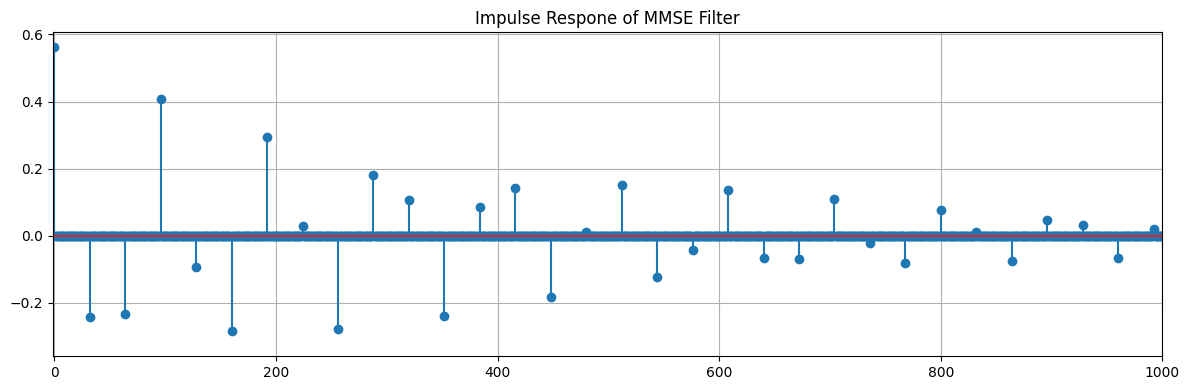

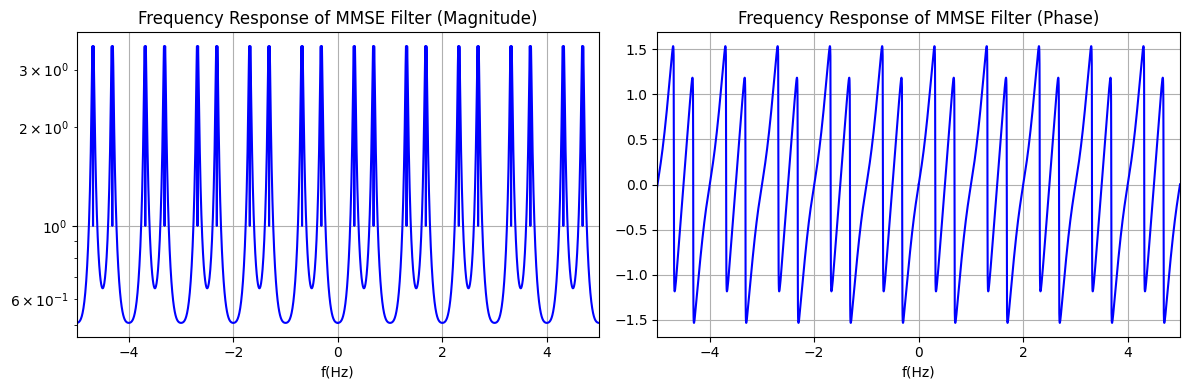

In [803]:
H = np.fft.fft(channel)
H_conj = np.conj(H)
mmse_filter = np.fft.ifft(H_conj / (H * H_conj + 2*noise_power))

plt.figure(figsize=(12,4))

plt.stem(mmse_filter)
plt.title('Impulse Respone of MMSE Filter')
plt.grid(True)
plt.xlim(-1,1000)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

Fs = 32
fft_values = np.fft.fft(mmse_filter)
N = len(fft_values)
n = np.arange(N)
T = N/Fs
freq = n/T
abs = np.abs(fft_values)

plt.subplot(1,2,1)
plt.semilogy(freq, abs, color='blue')
plt.semilogy(-freq, abs, color='blue')
plt.title('Frequency Response of MMSE Filter (Magnitude)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-5,5)

plt.subplot(1,2,2)
plt.plot(freq, np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.plot(-freq, -np.arctan2(np.imag(fft_values),np.real(fft_values)), color='blue')
plt.title('Frequency Response of MMSE Filter (Phase)')
plt.xlabel('f(Hz)')
plt.grid(True)
plt.xlim(-5,5)

plt.tight_layout()
plt.show()

The MMSE filter seems to be stable, since the impulse response is converging to zero.

#### Question 13

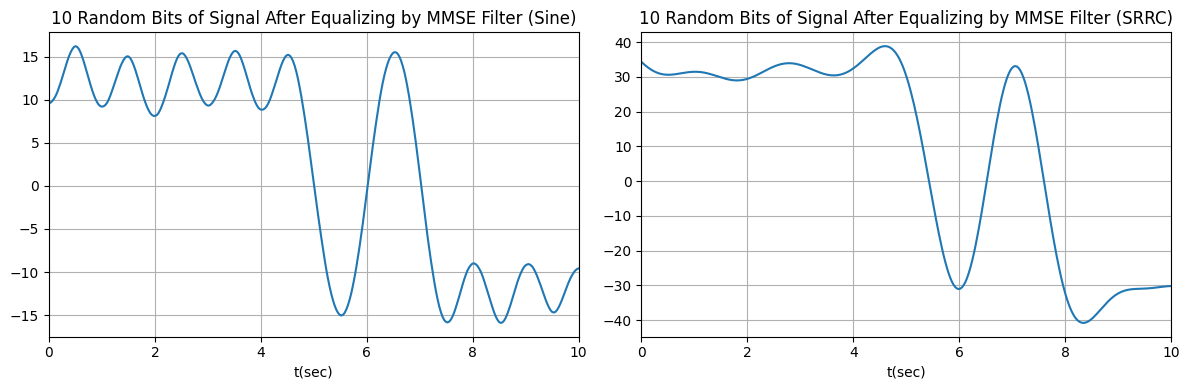

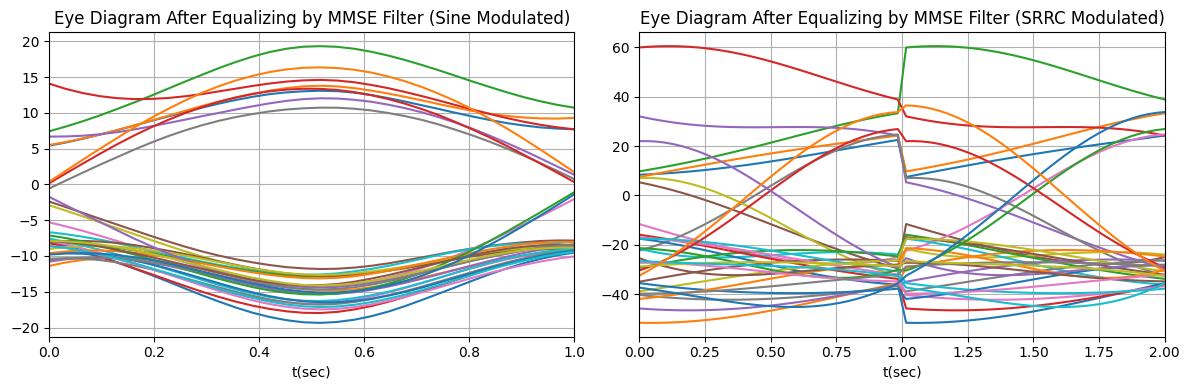

In [804]:
plt.figure(figsize=(12,4))

t = np.linspace(0,10,10*32)

mmse_equalized_signal_sine_10bit = mmse_signal_sine[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,1)
plt.plot(t,mmse_equalized_signal_sine_10bit)
plt.title('10 Random Bits of Signal After Equalizing by MMSE Filter (Sine)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

mmse_equalized_srrc_10bit = mmse_signal_srrc[i_random,j_random*32:j_random*32+10*32]

plt.subplot(1,2,2)
plt.plot(t,zf_equalized_srrc_10bit)
plt.title('10 Random Bits of Signal After Equalizing by MMSE Filter (SRRC)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))

t = np.linspace(0,1,32)

for i in range(int(mmse_signal_sine.shape[1]/bitstream.shape[1])):
    bit = mmse_signal_sine[2,i*32:(i+1)*32]
    plt.subplot(1,2,1)
    plt.plot(t,bit)

plt.title('Eye Diagram After Equalizing by MMSE Filter (Sine Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,1)

t = np.linspace(0,2,64)

for i in range(int(mmse_signal_srrc.shape[1]/bitstream.shape[1])):
    bit = mmse_signal_srrc[2,i*32:(i+2)*32]
    plt.subplot(1,2,2)
    plt.plot(t,bit)

plt.title('Eye Diagram After Equalizing by MMSE Filter (SRRC Modulated)')
plt.xlabel('t(sec)')
plt.grid(True)
plt.xlim(0,2)

plt.tight_layout()
plt.show()

We can see that the MMSE filter has retrieved the signal very well and now we can decide about the best sampling points.

The bset sampling ponits for the sine modulated signal are 0.5+nT and the best sampling ponits for the SRRC modulated signal are 1+nT.

## 3.8. Sampling and Detection

In [805]:
detected_bits_sine = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc = sample_and_detect(mmse_signal_srrc,'srrc')

## 3.9. Image Reconstruction

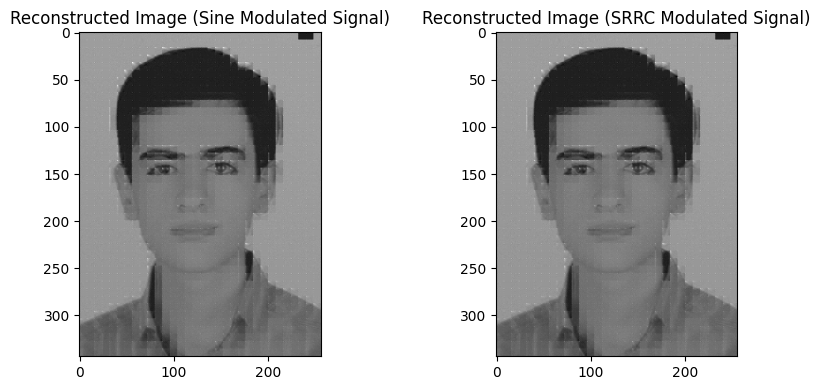

In [806]:
plt.figure(figsize=(9,4))

reconstructed_image_sine = reconstruct_image(detected_bits_sine, image.shape, max_value)
plt.subplot(1,2,1)
plt.imshow(reconstructed_image_sine,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated Signal)')

reconstructed_image_srrc = reconstruct_image(detected_bits_srrc, image.shape, max_value)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image_srrc,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated Signal)')

plt.tight_layout()
plt.show()

The reconstructed image has a checkered pattern. That's because we performed DCT algorithm on 8*8 blocks of image and then we quantized the values.

### Question 14

Note: Each section in this question takes a little time to run. Please be patient.

#### Noise Power = 0.01

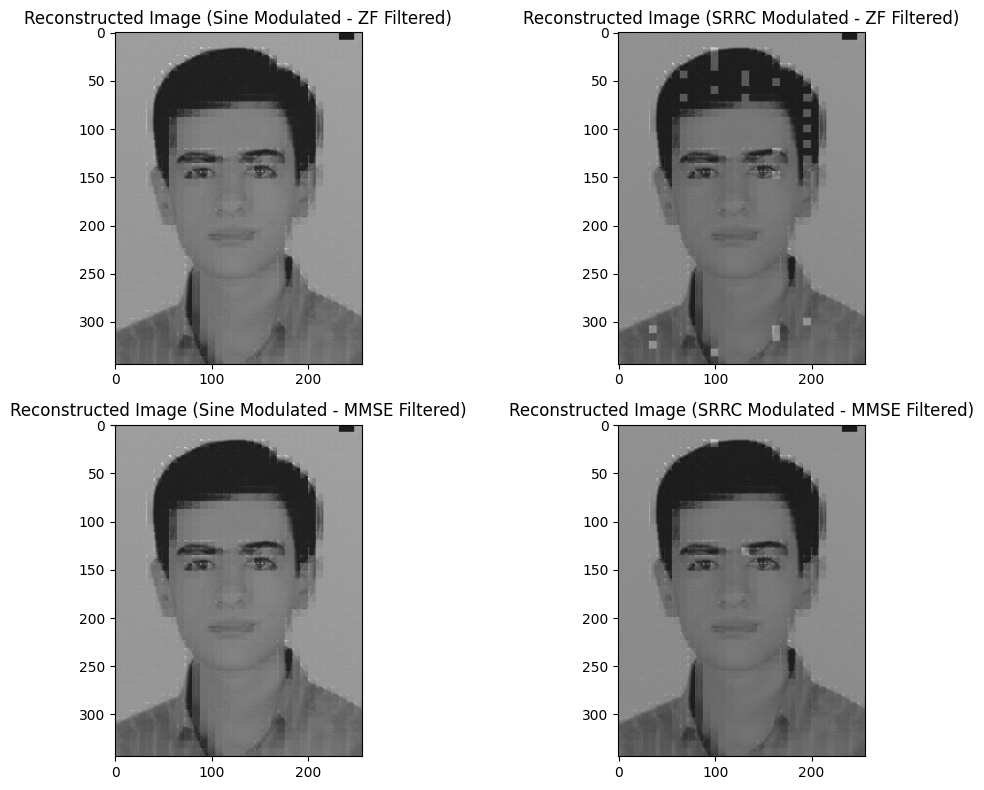

In [810]:
noise_power = 0.01

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 0.05

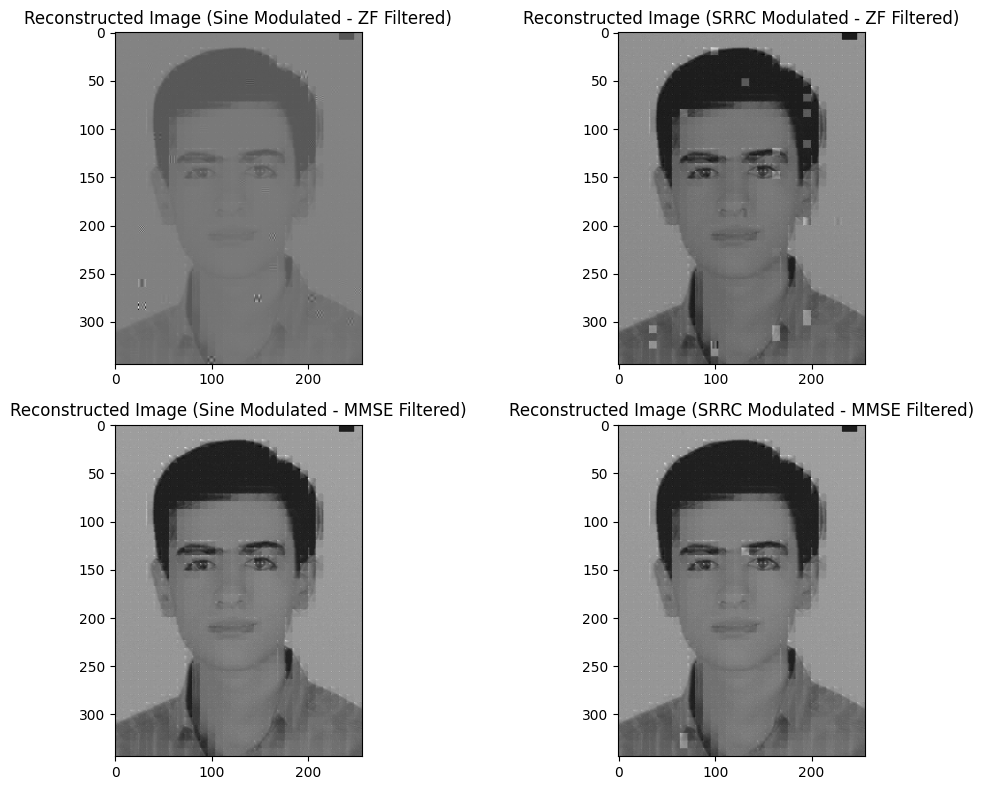

In [811]:
noise_power = 0.05

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 0.1

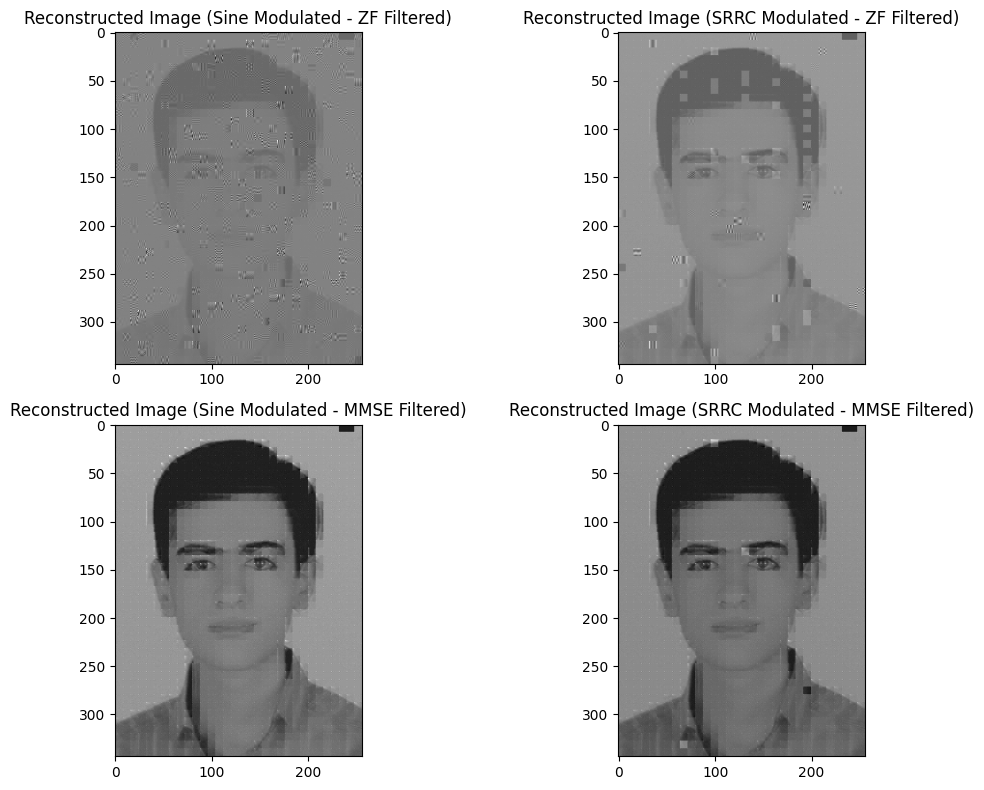

In [812]:
noise_power = 0.1

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 0.2

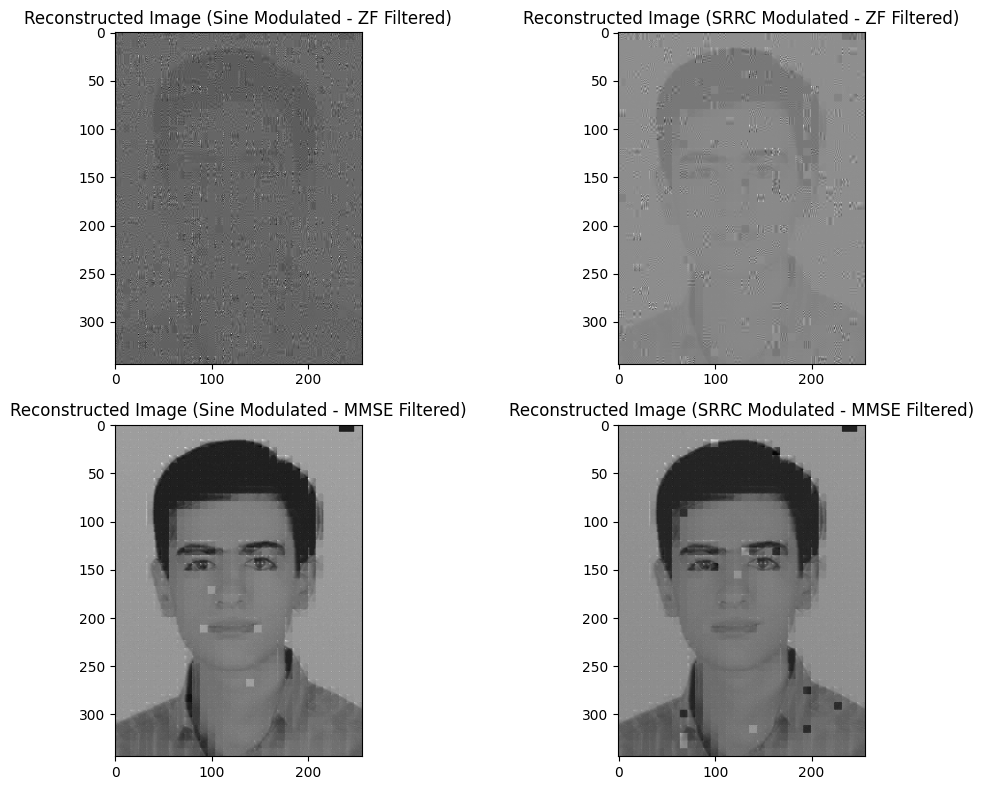

In [813]:
noise_power = 0.2

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 0.3

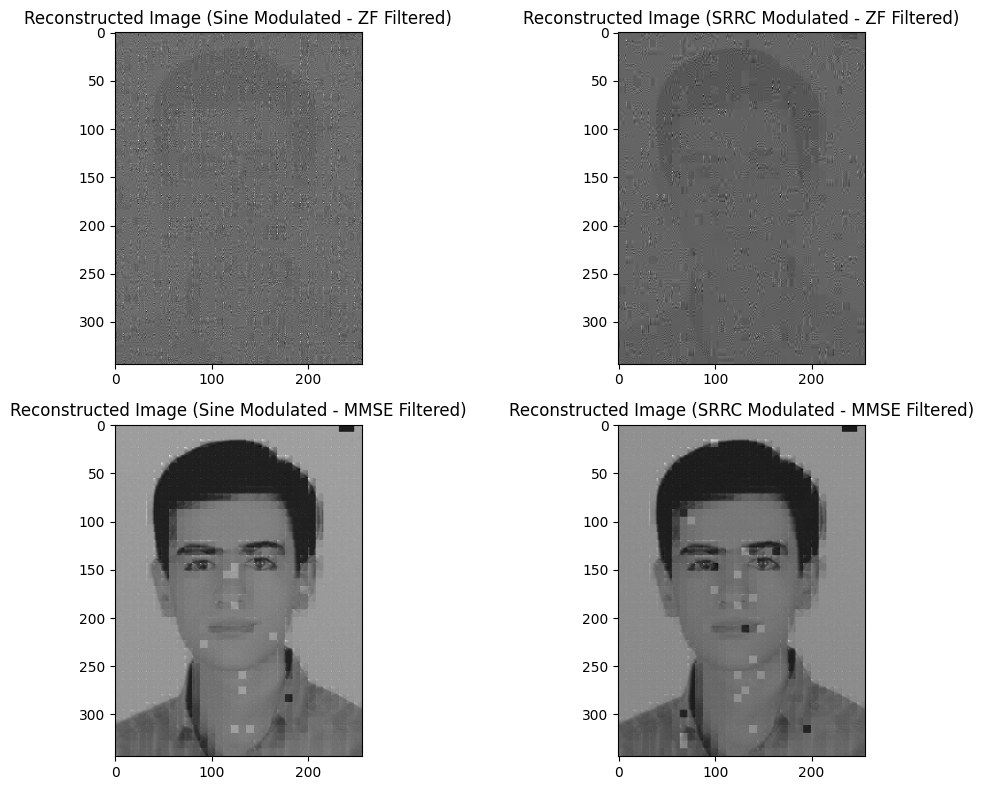

In [814]:
noise_power = 0.3

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 0.4

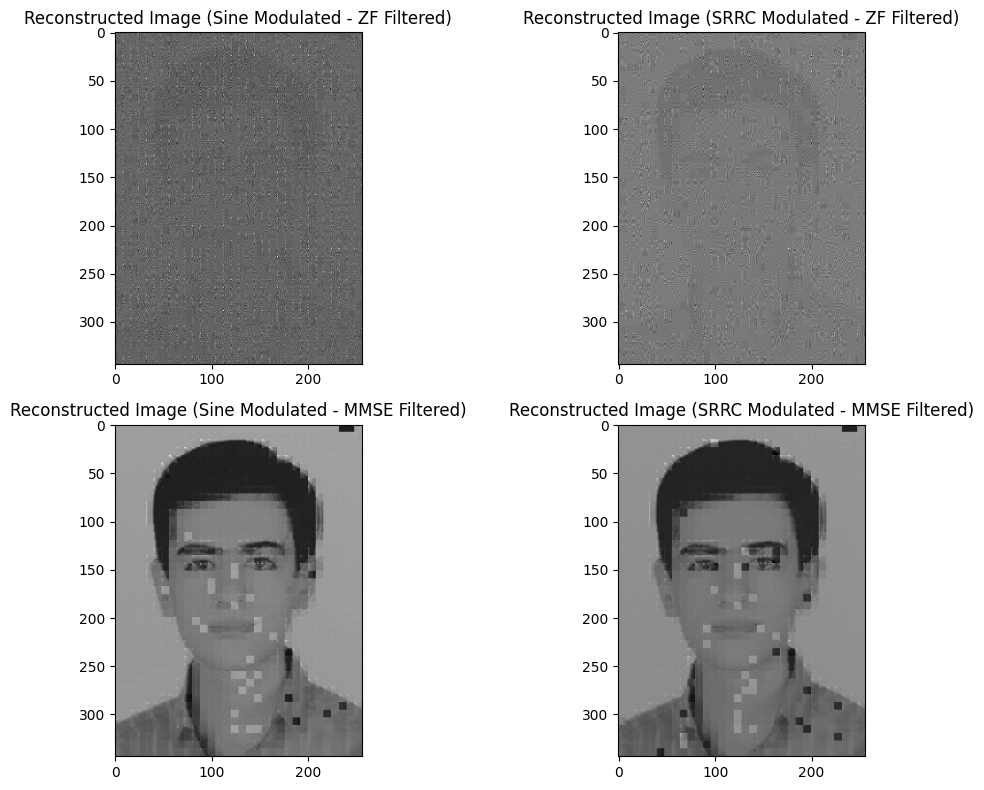

In [815]:
noise_power = 0.4

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 0.7

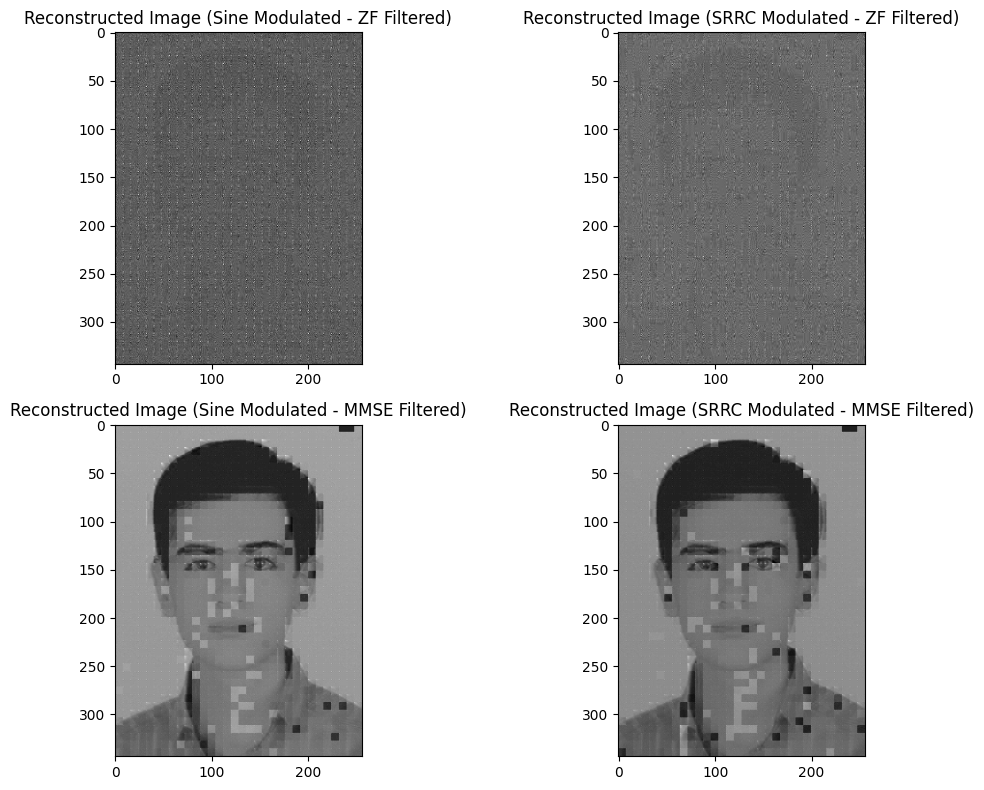

In [816]:
noise_power = 0.7

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 1

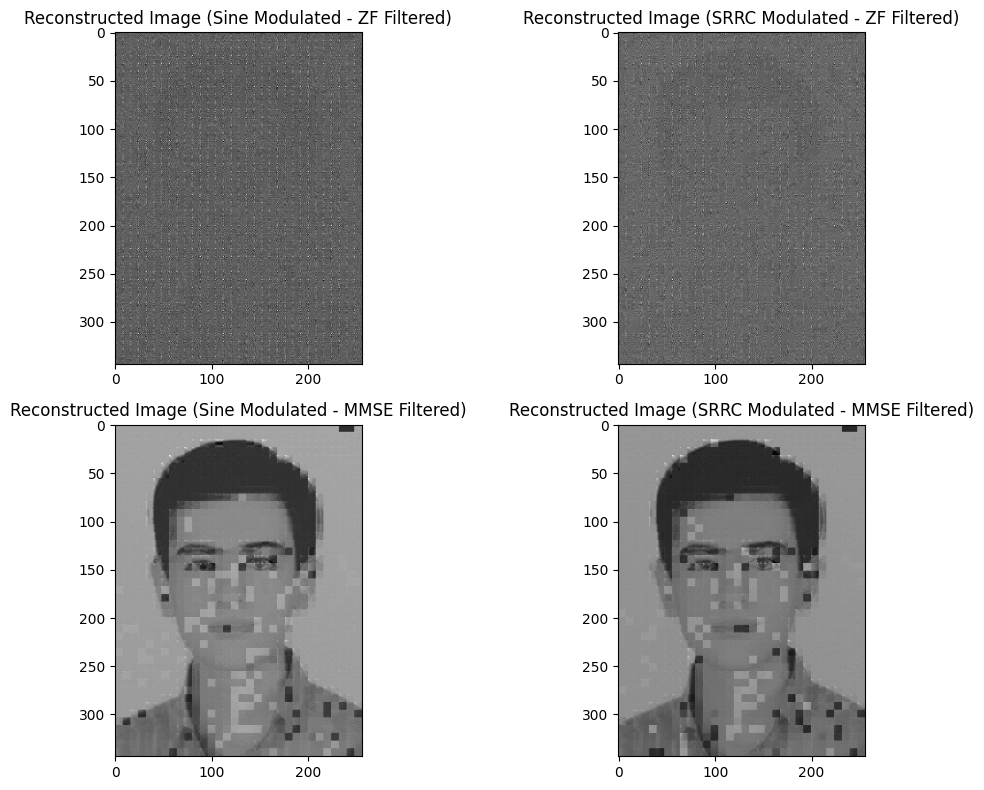

In [817]:
noise_power = 1

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 1.5

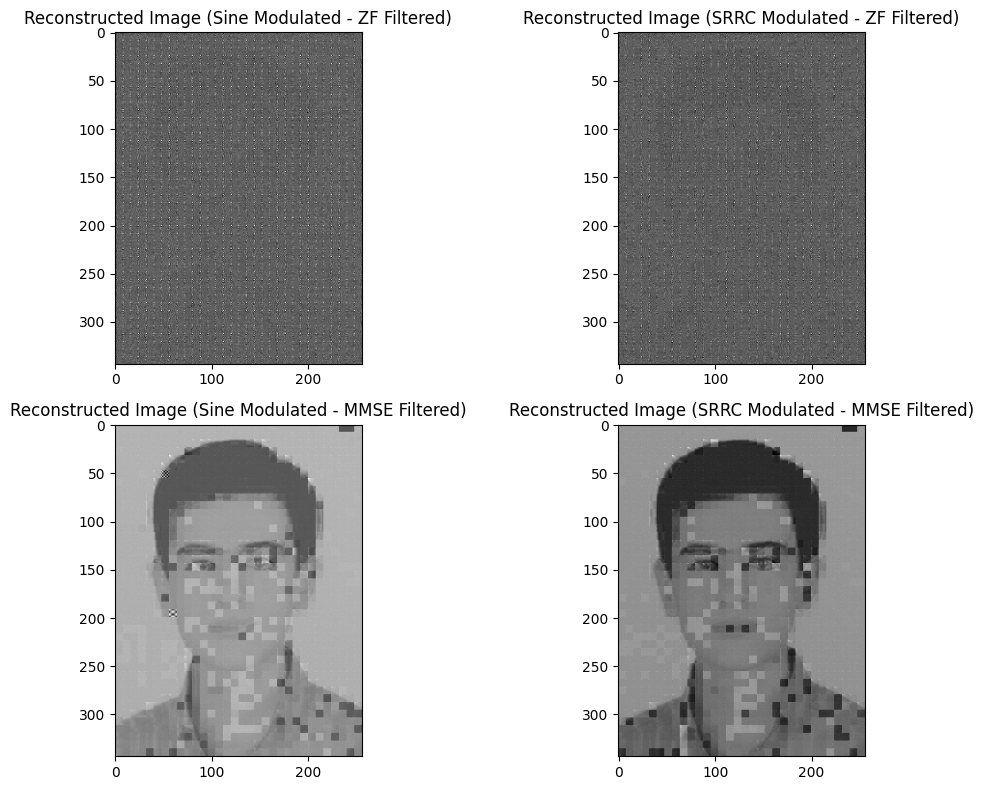

In [823]:
noise_power = 1.5

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Noise Power = 2

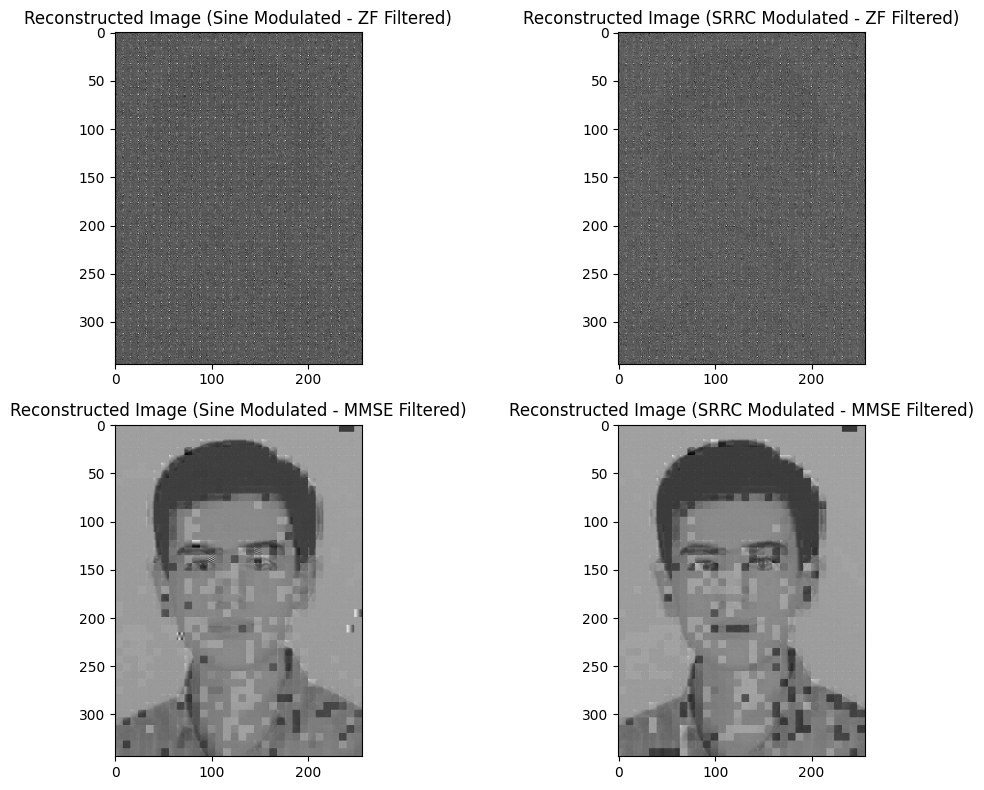

In [824]:
noise_power = 2

received_noisy_signal_sine = add_white_noise(received_signal_sine,np.sqrt(noise_power))
received_noisy_signal_srrc = add_white_noise(received_signal_srrc,np.sqrt(noise_power))

matched_signal_sine = matched_filter(received_noisy_signal_sine,'half_sine')
matched_signal_srrc = matched_filter(received_noisy_signal_srrc,'srrc')

zf_signal_sine = zero_forcing_equalizer(matched_signal_sine, channel)
zf_signal_srrc = zero_forcing_equalizer(matched_signal_srrc, channel)

mmse_signal_sine = mmse_equalizer(matched_signal_sine, channel, noise_power)
mmse_signal_srrc = mmse_equalizer(matched_signal_srrc, channel, noise_power)

detected_bits_sine_zf = sample_and_detect(zf_signal_sine,'half_sine')
detected_bits_srrc_zf = sample_and_detect(zf_signal_srrc,'srrc')

detected_bits_sine_mmse = sample_and_detect(mmse_signal_sine,'half_sine')
detected_bits_srrc_mmse = sample_and_detect(mmse_signal_srrc,'srrc')

reconstructed_image_sine_zf = reconstruct_image(detected_bits_sine_zf, image.shape, max_value)
reconstructed_image_srrc_zf = reconstruct_image(detected_bits_srrc_zf, image.shape, max_value)

reconstructed_image_sine_mmse = reconstruct_image(detected_bits_sine_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse = reconstruct_image(detected_bits_srrc_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

As we can see, MMSE filter works way better in peresence of noise, compared to zero-forcing filter.

# 4. Analysis

## 4.1. Effect of Noise and Equalization

#### Question 15

In [820]:
t = np.linspace(0, 1, 32)
sine_pulse = np.sin(np.pi*t)
sine_pulse_energy = np.mean(np.sum(sine_pulse**2))

def srrc_pulse(t, beta, T=1):
    if np.abs(t) < 1e-8:
         return 1 - beta + (4 * beta / np.pi)
    elif np.abs(t) == T / (4 * beta):
        return (beta / np.sqrt(2)) * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
    else:
        return (np.sin(np.pi * t * (1 - beta) / T) + 4 * beta * t / T * np.cos(np.pi * t * (1 + beta) / T)) / (np.pi * t * (1 - (4 * beta * t / T) ** 2) / T)

K = 6
beta = 0.5
t = np.linspace(-K, K, 2*K*32, endpoint=False)
srrc_pulse = np.array([srrc_pulse(i, beta) for i in t])
srrc_pulse_energy = np.mean(np.sum(srrc_pulse**2))

print(f'Energy of half sine pulse is {sine_pulse_energy}')
print(f'Energy of srrc pulse is {srrc_pulse_energy}')

Energy of half sine pulse is 15.5
Energy of srrc pulse is 31.998743620500363


In [822]:
sine_zf_critical_SNR = sine_pulse_energy / 0.05
srrc_zf_critical_SNR = srrc_pulse_energy / 0.1
sine_mmse_critical_SNR = sine_pulse_energy / 1
srrc_mmse_critical_SNR = srrc_pulse_energy / 0.7
print(f'Critical SNR for ZF filtered half sine pulse is {sine_zf_critical_SNR}')
print(f'Critical SNR for ZF filtered ssrc pulse is {srrc_zf_critical_SNR}')
print(f'Critical SNR for MMSE filtered half sine pulse is {sine_mmse_critical_SNR}')
print(f'Critical SNR for MMSE filtered ssrc pulse is {srrc_mmse_critical_SNR}')

Critical SNR for ZF filtered half sine pulse is 310.0
Critical SNR for ZF filtered ssrc pulse is 319.98743620500363
Critical SNR for MMSE filtered half sine pulse is 15.5
Critical SNR for MMSE filtered ssrc pulse is 45.712490886429094


As we can see the half sine pulse has a higher immunity against noise. But In reality, such time-limited pulse is not band-limited in frequency domain and since the channel has a limited bandwidth, the pulse loses a part of its information. This will lead to ISI, so we use pulses like srrc, that have almost band-limited characteristics.

#### Question 16

I have already done this in question 14 :)

## 4.2. Effect of Pulse Shape

#### Question 17

Half-sine, although it has a limited frequency spectrum, does not fully satisfy the Nyquist criterion, as it may have nonzero values at sampling points, leading to ISI.

SRRC pulse is specifically designed for communication systems to minimize ISI. If SRRC filters are correctly applied at both the transmitter and receiver, their combined response results in a Raised Cosine filter, which satisfies the Nyquist criterion, ensuring that the signal has zero values at all sampling points except its peak.

Zero-ISI should be achieved at the sampling points after the equalizer, rather than immediately after the matched filter. The matched filter optimizes the Signal-to-Noise Ratio but does not necessarily eliminate ISI and the output of the matched filter may still contain ISI.

Equalizers such as Zero-Forcing Equalizer and MMSE Equalizer are specifically designed to counteract the effects of the channel and reduce ISI. If the modulation pulses and filter design are correct, Zero-ISI should be observed after the equalizer at the sampling points.

The eye diagrams also confirm these facts. As we can see, the eye diagrams after matched filter are still closed and messy but after equalizers, they eye-opening areas have become wider and opener.

#### Question 18

A difference in error performance is expected despite both pulse shaping functions having the same energy. The primary reasons for this include:

1. **Spectral Efficiency and Bandwidth Occupation:**
    - The Half-Sine Pulse has a wider bandwidth and exhibits more spectral spreading, which can result in greater sensitivity to channel impairments and noise.
    - The SRRC Pulse has a well-controlled bandwidth and is designed to minimize ISI when correctly filtered, leading to better resilience against noise.

2. **Inter-Symbol Interference (ISI):**
    - The Half-Sine Pulse may introduce more ISI due to its spectral characteristics, especially when passing through a non-ideal channel.
    - The SRRC Pulse is designed to reduce ISI, particularly when used with a matched filter at the receiver.

3. **Matched Filtering & Signal-to-Noise Ratio (SNR):**
    - The SRRC Pulse, when paired with an SRRC matched filter, provides an optimal detection condition, improving the effective SNR at the sampling point.
    - The Half-Sine Pulse, while still benefiting from a matched filter, does not achieve the same level of SNR optimization due to its spectral shape.

#### Question 19

The choice of pulse shaping directly influences the bandwidth of the transmitted signal. Here’s how the two pulse shapes compare:

1. **Half-Sine Pulse:**
    - Occupies a relatively wide bandwidth due to its sharp transitions in the time domain.
    - It has a sinc-like spectrum with significant side lobes, which means more power is spread across a broader frequency range.
    - Less spectrally efficient, leading to potential interference with adjacent channels.
  
2. **SRRC Pulse:**
    - More spectrally efficient due to its controlled roll-off factor (β).
    - Reduces out-of-band energy, making it ideal for minimizing adjacent channel interference.
    - The roll-off factor (β) determines the excess bandwidth; for β = 0, it achieves the theoretical Nyquist bandwidth, while for higher β values, it occupies more bandwidth but ensures better ISI mitigation.
  
The pulse duration, measured in terms of bit periods, affects both ISI and system bandwidth.

1. **Shorter Pulse Duration:**
    - Leads to higher bandwidth consumption due to the inverse relationship between time duration and frequency spread.
    - Increases the risk of ISI since pulses overlap more in the time domain.
    - Requires more precise timing recovery at the receiver.

2. **Longer Pulse Duration:**
    - Reduces bandwidth usage, leading to better spectral efficiency.
    - Helps minimize ISI when paired with an appropriate filter, as seen in SRRC pulses.
    - However, longer pulses require larger memory and buffering at the receiver, increasing processing complexity.

#### Question 20

Based on the analysis of bandwidth efficiency, inter-symbol interference (ISI), and system performance, the SRRC (Square Root Raised Cosine) pulse is generally the better choice for communication systems.

**Advantages of the SRRC Pulse:**
1. **Minimizes ISI:**
    - When correctly filtered, the combined response of the transmitter and receiver forms a Raised Cosine filter, ensuring that ISI is eliminated at sampling points.
2. **Efficient Bandwidth Usage:**
    - The roll-off factor (β) allows control over bandwidth occupation.
    - Unlike the Half-Sine pulse, it reduces spectral leakage, preventing interference with adjacent channels.
3. **Better Noise Resilience:**
    - Due to its smoother spectral characteristics, it improves Signal-to-Noise Ratio (SNR) at the receiver, especially when using a matched filter.
4. **Flexible Design:**
    - The ability to adjust β allows system designers to trade between bandwidth efficiency and ease of equalization.

**Disadvantages of the SRRC Pulse:**
1. **Increased Complexity:**
    - Requires precise implementation of matched filters at both the transmitter and receiver.
    - The system needs accurate synchronization and equalization to ensure Zero-ISI.
2. **Longer Pulse Duration:**
    - SRRC pulses extend beyond a single bit period, leading to longer memory requirements and higher computational cost.
    - A higher truncation length (K) is needed to approximate an ideal SRRC pulse, increasing processing complexity.
3. **Higher Sensitivity to Timing Errors:**
    - If the sampling timing is not perfectly aligned, the Zero-ISI condition may not hold, degrading performance.


## 4.3. Effect of Channel

Note: Since these channels have longer delays, the code may take a little longer to run.

### Channel H1

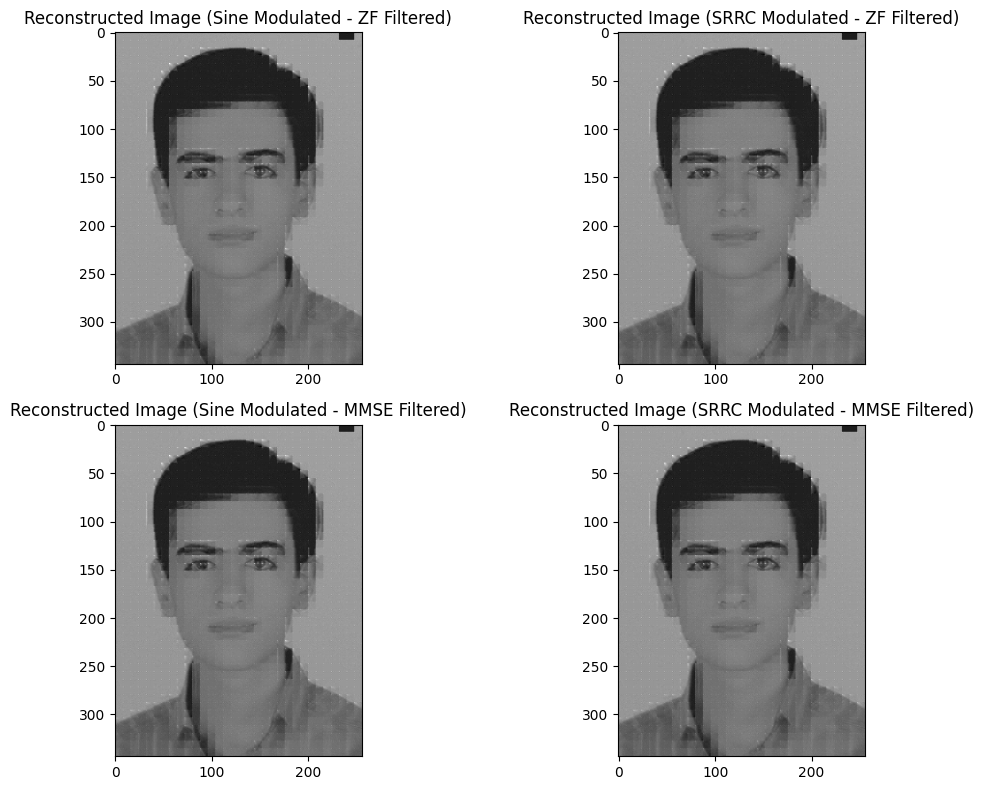

In [829]:
h1 = np.zeros_like(modulated_signal_sine[0,:])
h1[0] = 0.5
h1[32] = 1
h1[96] = 0.63
h1[256] = 0.25
h1[384] = 0.16
h1[800] = 0.1

received_signal_sine_h1 = np.zeros_like(modulated_signal_sine)
received_signal_srrc_h1 = np.zeros_like(modulated_signal_srrc)

for i in range(received_signal_sine_h1.shape[0]):
    received_signal_sine_h1[i,:] = transmit_through_channel(modulated_signal_sine[i,:],h1)

for i in range(received_signal_srrc_h1.shape[0]):
    received_signal_srrc_h1[i,:] = transmit_through_channel(modulated_signal_srrc[i,:],h1)

noise_power = 0.1
received_noisy_signal_sine_h1 = add_white_noise(received_signal_sine_h1,np.sqrt(noise_power))
received_noisy_signal_srrc_h1 = add_white_noise(received_signal_srrc_h1,np.sqrt(noise_power))

matched_signal_sine_h1 = matched_filter(received_noisy_signal_sine_h1,'half_sine')
matched_signal_srrc_h1 = matched_filter(received_noisy_signal_srrc_h1,'srrc')

zf_signal_sine_h1 = zero_forcing_equalizer(matched_signal_sine_h1, h1)
zf_signal_srrc_h1 = zero_forcing_equalizer(matched_signal_srrc_h1, h1)

mmse_signal_sine_h1 = mmse_equalizer(matched_signal_sine_h1, h1, noise_power)
mmse_signal_srrc_h1 = mmse_equalizer(matched_signal_srrc_h1, h1, noise_power)

detected_bits_sine_h1_zf = sample_and_detect(zf_signal_sine_h1,'half_sine')
detected_bits_srrc_h1_zf = sample_and_detect(zf_signal_srrc_h1,'srrc')

detected_bits_sine_h1_mmse = sample_and_detect(mmse_signal_sine_h1,'half_sine')
detected_bits_srrc_h1_mmse = sample_and_detect(mmse_signal_srrc_h1,'srrc')

reconstructed_image_sine_zf_h1 = reconstruct_image(detected_bits_sine_h1_zf, image.shape, max_value)
reconstructed_image_srrc_zf_h1 = reconstruct_image(detected_bits_srrc_h1_zf, image.shape, max_value)

reconstructed_image_sine_mmse_h1 = reconstruct_image(detected_bits_sine_h1_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse_h1 = reconstruct_image(detected_bits_srrc_h1_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf_h1,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf_h1,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse_h1,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse_h1,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

### Channel H2

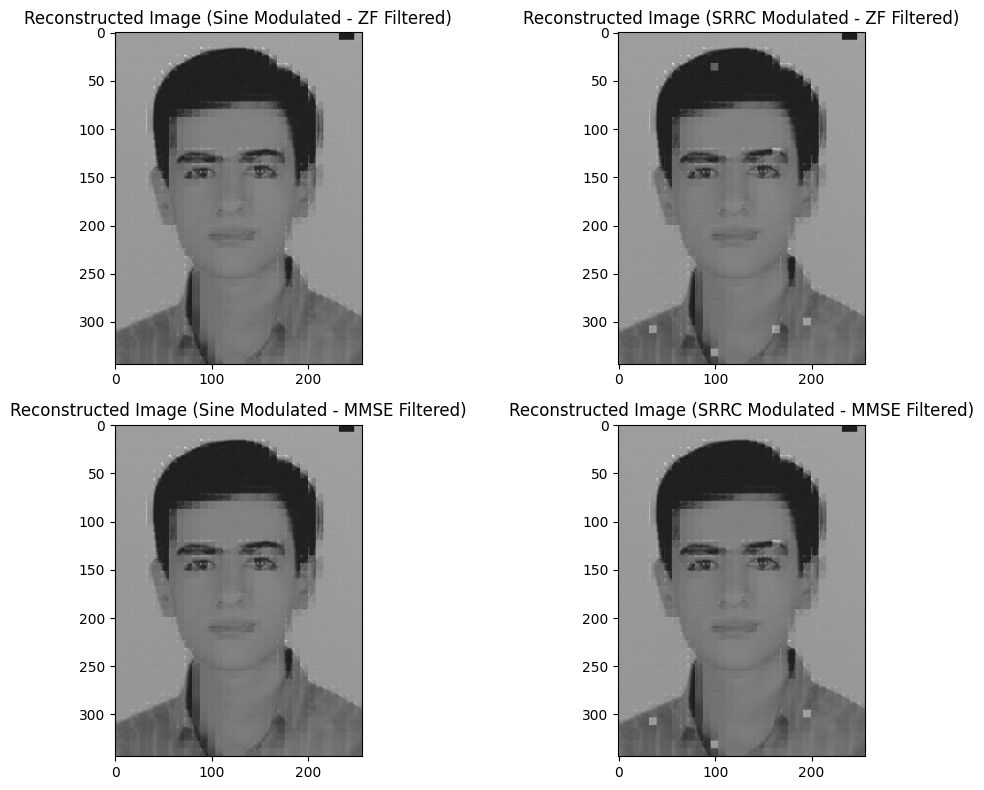

In [830]:
h2 = np.zeros_like(modulated_signal_sine[0,:])
h2[0] = 1
h2[32] = 0.4365
h2[64] = 0.1905
h2[96] = 0.0832
h2[165] = 0.0158
h2[224] = 0.003

received_signal_sine_h2 = np.zeros_like(modulated_signal_sine)
received_signal_srrc_h2 = np.zeros_like(modulated_signal_srrc)

for i in range(received_signal_sine_h2.shape[0]):
    received_signal_sine_h2[i,:] = transmit_through_channel(modulated_signal_sine[i,:],h2)

for i in range(received_signal_srrc_h2.shape[0]):
    received_signal_srrc_h2[i,:] = transmit_through_channel(modulated_signal_srrc[i,:],h2)

noise_power = 0.1
received_noisy_signal_sine_h2 = add_white_noise(received_signal_sine_h2,np.sqrt(noise_power))
received_noisy_signal_srrc_h2 = add_white_noise(received_signal_srrc_h2,np.sqrt(noise_power))

matched_signal_sine_h2 = matched_filter(received_noisy_signal_sine_h2,'half_sine')
matched_signal_srrc_h2 = matched_filter(received_noisy_signal_srrc_h2,'srrc')

zf_signal_sine_h2 = zero_forcing_equalizer(matched_signal_sine_h2, h2)
zf_signal_srrc_h2 = zero_forcing_equalizer(matched_signal_srrc_h2, h2)

mmse_signal_sine_h2 = mmse_equalizer(matched_signal_sine_h2, h2, noise_power)
mmse_signal_srrc_h2 = mmse_equalizer(matched_signal_srrc_h2, h2, noise_power)

detected_bits_sine_h2_zf = sample_and_detect(zf_signal_sine_h2,'half_sine')
detected_bits_srrc_h2_zf = sample_and_detect(zf_signal_srrc_h2,'srrc')

detected_bits_sine_h2_mmse = sample_and_detect(mmse_signal_sine_h2,'half_sine')
detected_bits_srrc_h2_mmse = sample_and_detect(mmse_signal_srrc_h2,'srrc')

reconstructed_image_sine_zf_h2 = reconstruct_image(detected_bits_sine_h2_zf, image.shape, max_value)
reconstructed_image_srrc_zf_h2 = reconstruct_image(detected_bits_srrc_h2_zf, image.shape, max_value)

reconstructed_image_sine_mmse_h2 = reconstruct_image(detected_bits_sine_h2_mmse, image.shape, max_value)
reconstructed_image_srrc_mmse_h2 = reconstruct_image(detected_bits_srrc_h2_mmse, image.shape, max_value)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image_sine_zf_h2,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - ZF Filtered)')

plt.subplot(2,2,2)
plt.imshow(reconstructed_image_srrc_zf_h2,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - ZF Filtered)')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image_sine_mmse_h2,cmap=plt.cm.gray)
plt.title('Reconstructed Image (Sine Modulated - MMSE Filtered)')

plt.subplot(2,2,4)
plt.imshow(reconstructed_image_srrc_mmse_h2,cmap=plt.cm.gray)
plt.title('Reconstructed Image (SRRC Modulated - MMSE Filtered)')

plt.tight_layout()
plt.show()

#### Question 21

It Looks like channel h1 works better against noise.